## Parameter Estimation

Users can:
    
    - Set which parameters to estimate
    - Set boundaries of optimization problem
    - Choose algorithm and set algorithm specific parameters
    - Configure report options (which parameters to include, name, append etc.)
    - Map arbitrary number of data files to fit at once
    - Choose between time course or steady state
      

To do:

    - Support for affected experiments section



## Imports and Getting Test Model

In [1]:
%matplotlib inline
import site
site.addsitedir('/home/b3053674/Documents/pycotools')
from pycotools import model, tasks, viz, misc
from pycotools.Models.zi_model_variants import Models
import os
import pandas
from lxml import etree

## get string model from test_models
zi_model_string = Models().published_zi

## get a working directory. Change this to change this to wherever you like
directory = r'/home/b3053674/Documents/Models/2017/10_Oct/TutorialWorkspace'

## choose path to zi model
zi_path = os.path.join(directory, 'zi2012.cps')

##write model to file
with open(zi_path, 'w') as f:
    f.write(zi_model_string)
    
## check file exists
if not os.path.isfile(zi_path):
    raise Exception
    
zi = model.Model(zi_path)

/home/b3053674/Documents/pycotools/pycotools/viz.py:117: FutureWarning: The pandas.parser module is deprecated and will be removed in a future version. Please import from the pandas.io.parser instead
  from pandas.parser import CParserError


root:INFO:27:    Initializing pycotools
root:INFO:28:    Initializing logging System
root:INFO:29:    logging config file at: /home/b3053674/Documents/pycotools/pycotools/logging_config.conf


### Simulate Synthetic Data for Demonstration

In [2]:
report= 'parameter_estimation_synthetic_data.txt'
TC=tasks.TimeCourse(
    zi, start=0, end=1000, intervals=10, step_size=100, report_name=report
)

## validate that its worked
pandas.read_csv(TC.report_name,sep='\t').head()

Time  [Smad4n]  [Smad4c]  [Smad3n]  [Smad3c]  [T2R_Surf]  [T1R_EE]  \
0     0   551.720   1149.40   236.450   492.610    0.202000  2.060000   
1   100   539.437    945.10   187.070   300.676    0.042480  0.153971   
2   200   543.973   1020.66   205.334   371.659    0.090375  0.019241   
3   300   545.077   1045.27   211.116   394.709    0.112896  0.009298   
4   400   545.245   1049.48   212.097   398.651    0.122516  0.007748   

   [T1R_Cave]  [T1R_Surf]  [T2R_EE]            ...              Values[Kcd]  \
0    2.092000    0.237000  1.148000            ...                    0.005   
1    0.159964    0.005712  0.192643            ...                    0.005   
2    0.019872    0.001432  0.476866            ...                    0.005   
3    0.009471    0.000980  0.625865            ...                    0.005   
4    0.007873    0.000869  0.690089            ...                    0.005   

   Values[kr_Cave]  Values[ki_Cave]  Values[Kexp_Smad4n]  \
0          0.03742             0.33                  0.5   
1          0.03742             0.33                  0.5   
2          0.03742             0.33                  0.5   
3          0.03742             0.33                  0.5   
4          0.03742             0.33                  0.5   

   Values[Kdiss_Smads_Complex_n]  Values[Kimp_Smad2c]  \
0                         0.1174                 0.16   
1                         0.1174                 0.16   
2                         0.1174                 0.16   
3                         0.1174                 0.16   
4                         0.1174                 0.16   

   Values[Kimp_Smads_Complex_c]  Values[Kimp_Smad4c]  Values[Kdeg_T2R_EE]  \
0                          0.16                 0.08                0.025   
1                          0.16                 0.08                0.025   
2                          0.16                 0.08                0.025   
3                          0.16                 0.08                0.025   
4                          0.16                 0.08                0.025   

   Values[k_Smads_Complex_c]  
0                   0.000069  
1                   0.000069  
2                   0.000069  
3                   0.000069  
4                   0.000069  

[5 rows x 37 columns]

Give the data a more meaningful name

In [3]:
zi_data_file = TC.report_name

### Parameter Estimation Data Files
Rules to follow:

    - Column headings must match model variables exactly in order to be mapped. 
    - Independant variables can be mapped by appending the suffix `_indep` to the variable.
        - For example, if you vary the concentration of A between 0 and 10ng/mL in an experiment:
        
                Time A_indep  B   C
                t=1   0       -   - 
                t=2   0           -
                t=3  10           -
                t=4  10       -   -
    - Do not use non-asci strings (i.e. greek alpha or beta) in parameter definitions. They are minimally supported but this is unstable. 

Copasi time course output contains additional content in headers (i.e. `Values[specie_x]` instead of just `species_x`). For this demonstration to work the column headers must exactly match model variables. The `misc.correct_copasi_timecourse_headers` function specifically deals with this issue for us.  This occurs inplace (i.e. changes the content of the file) and returns the data as a `pandas.DataFrame`)

In [4]:
misc.format_timecourse_data(zi_data_file)

Time   Smad4n   Smad4c   Smad3n   Smad3c  T2R_Surf    T1R_EE  T1R_Cave  \
0      0  551.720  1149.40  236.450  492.610  0.202000  2.060000  2.092000   
1    100  539.437   945.10  187.070  300.676  0.042480  0.153971  0.159964   
2    200  543.973  1020.66  205.334  371.659  0.090375  0.019241  0.019872   
3    300  545.077  1045.27  211.116  394.709  0.112896  0.009298  0.009471   
4    400  545.245  1049.48  212.097  398.651  0.122516  0.007748  0.007873   
5    500  545.270  1050.11  212.243  399.238  0.126573  0.007242  0.007356   
6    600  545.274  1050.21  212.265  399.329  0.128277  0.006983  0.007092   
7    700  545.274  1050.22  212.269  399.344  0.128991  0.006808  0.006915   
8    800  545.274  1050.22  212.269  399.345  0.129289  0.006669  0.006772   
9    900  545.274  1050.22  212.269  399.344  0.129412  0.006545  0.006647   
10  1000  545.274  1050.22  212.268  399.341  0.129462  0.006430  0.006530   

    T1R_Surf    T2R_EE        ...            Kcd  kr_Cave  ki_Cave  \
0   0.237000  1.148000        ...          0.005  0.03742     0.33   
1   0.005712  0.192643        ...          0.005  0.03742     0.33   
2   0.001432  0.476866        ...          0.005  0.03742     0.33   
3   0.000980  0.625865        ...          0.005  0.03742     0.33   
4   0.000869  0.690089        ...          0.005  0.03742     0.33   
5   0.000824  0.717217        ...          0.005  0.03742     0.33   
6   0.000798  0.728619        ...          0.005  0.03742     0.33   
7   0.000779  0.733399        ...          0.005  0.03742     0.33   
8   0.000764  0.735394        ...          0.005  0.03742     0.33   
9   0.000750  0.736221        ...          0.005  0.03742     0.33   
10  0.000737  0.736556        ...          0.005  0.03742     0.33   

    Kexp_Smad4n  Kdiss_Smads_Complex_n  Kimp_Smad2c  Kimp_Smads_Complex_c  \
0           0.5                 0.1174         0.16                  0.16   
1           0.5                 0.1174         0.16                  0.16   
2           0.5                 0.1174         0.16                  0.16   
3           0.5                 0.1174         0.16                  0.16   
4           0.5                 0.1174         0.16                  0.16   
5           0.5                 0.1174         0.16                  0.16   
6           0.5                 0.1174         0.16                  0.16   
7           0.5                 0.1174         0.16                  0.16   
8           0.5                 0.1174         0.16                  0.16   
9           0.5                 0.1174         0.16                  0.16   
10          0.5                 0.1174         0.16                  0.16   

    Kimp_Smad4c  Kdeg_T2R_EE  k_Smads_Complex_c  
0          0.08        0.025           0.000069  
1          0.08        0.025           0.000069  
2          0.08        0.025           0.000069  
3          0.08        0.025           0.000069  
4          0.08        0.025           0.000069  
5          0.08        0.025           0.000069  
6          0.08        0.025           0.000069  
7          0.08        0.025           0.000069  
8          0.08        0.025           0.000069  
9          0.08        0.025           0.000069  
10         0.08        0.025           0.000069  

[11 rows x 37 columns]

## Setup and run single parameter estimation 

Method outline:

    1) Instantiate ParameterEstimation instance with model and data filenames
        - Ensure optional arguments are specified to the ParameterEstimation class
    2) Use `write_config_template()` method to write and configure a parameter estimation config file.
    2) Use `setup()` method
    3) Use `run()` method
    4) Use `format_results()` method (to give output results meaningful headers)

### Use HookeJeeves algorithm

In [5]:
PE=tasks.ParameterEstimation(zi, zi_data_file, method='hooke_jeeves')

### Use particle swarm algorithm

In [6]:
PE=tasks.ParameterEstimation(zi, zi_data_file, method='particle_swarm')

### Use genetic algorithm

In [7]:
## Set getetic algorithm parameters to low for speed of demonstration
PE=tasks.ParameterEstimation(zi, zi_data_file, method='genetic_algorithm', 
                             population_size=15, number_of_generations=10)

### Write and configure item template

In [8]:
PE.write_config_file()
os.path.isfile(PE.config_filename)

True

#### Configure manually
Now you can go to where the file was saved and modify it how you like.

    - Delete rows with parameters you want not to be included in estimation
    - Change starting values, lower bounds and upper bounds
        - If you set start values, remember to set the randomize_start_values variable to False as it defaults to True

This is a useful way of running parameter estimations as it provides a record of how you've configured parameter estimations. 

#### Configure with API
The `metabolites`, `global_parameters` and `local_parameters` arguments tell Pycotools which parameters to include in the config file. By default all model parameters are included but these can be overridden by giving our own lists. 

For example, here we set `metabolites` and `globl_quantities` to empty lists to specify that we do not want to include them in the estimation process. We can also use the `upper_bound` and `lower_bound` arguments to constrain the estimation problem. An argument can also be given to `start_value` but parameter estimation is usually better performed multiple times with randomized start values (or with latin hypercube sampling but this is not supported here).

In [9]:
config_file = os.path.join(os.path.dirname(zi_path), 'Zi2002PEConfig.csv')
PE = tasks.ParameterEstimation(
    zi, zi_data_file, method='genetic_algorithm', population_size=15,
    number_of_generations=10, metabolites=[], local_parameters=[],
    lower_bound = 0.001, upper_bound = 3000, config_filename = config_file)

Here we've defined a config file with only kinetic parameters estimated between the boundaries of 0.1 and 100. 

In [10]:
if os.path.isfile(PE.config_filename):
    os.remove(PE.config_filename)
    
PE.write_config_file()

## check that the config filename exists
print (os.path.isfile(PE.config_filename))
PE.config_filename

True


'/home/b3053674/Documents/Models/2017/10_Oct/TutorialWorkspace/Zi2002PEConfig.csv'

### Setup and run parameter estimation

In [11]:
PE.setup()

Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol)

It can sometime be helpful to open the GUI and manually check that you've set all the options currectly. Run the next cell to open the model:

In [12]:
zi.open()

### Run with CopasiSE

In [13]:
PE.run() # will take some time depending on arguments to ParameterEstimation

## Visualization 
### Plot all estimated parameters

/home/b3053674/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


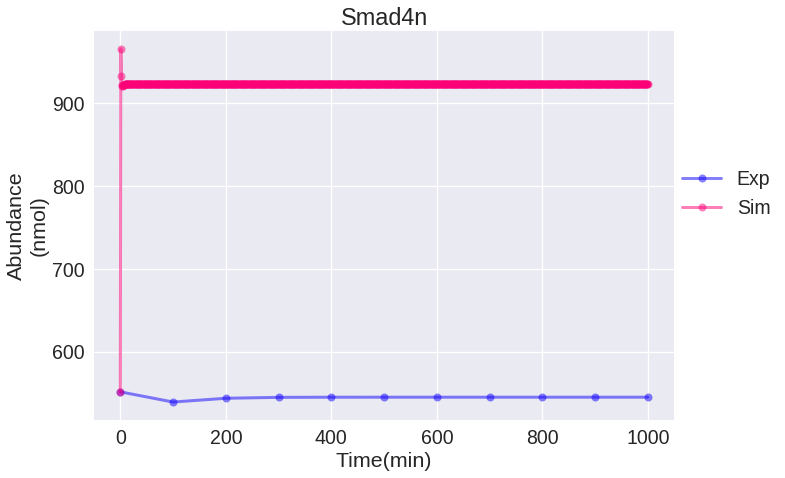

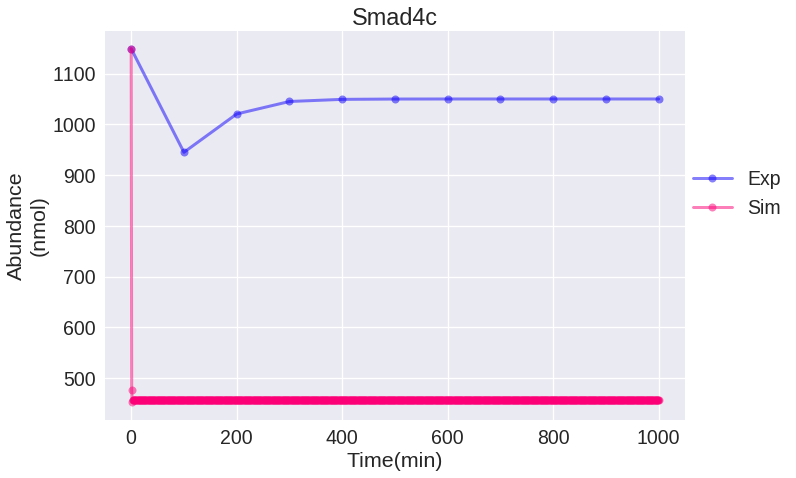

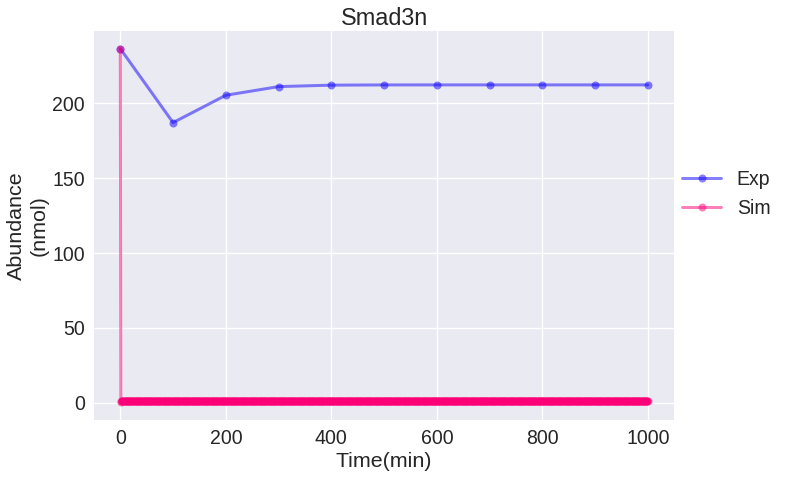

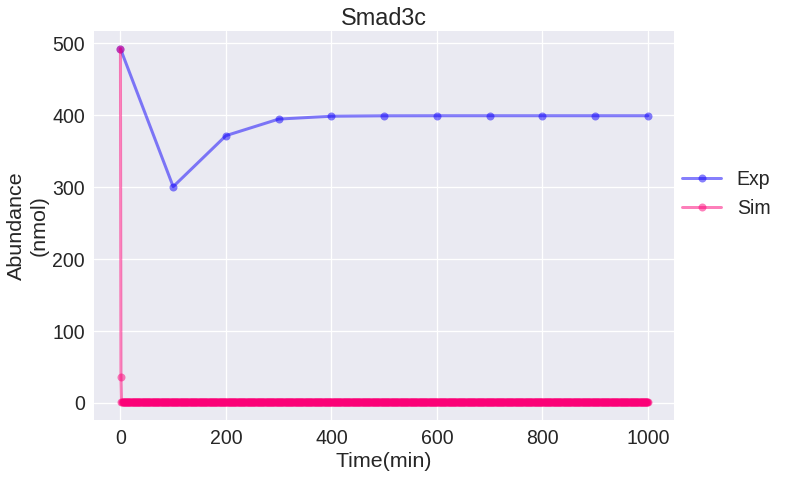

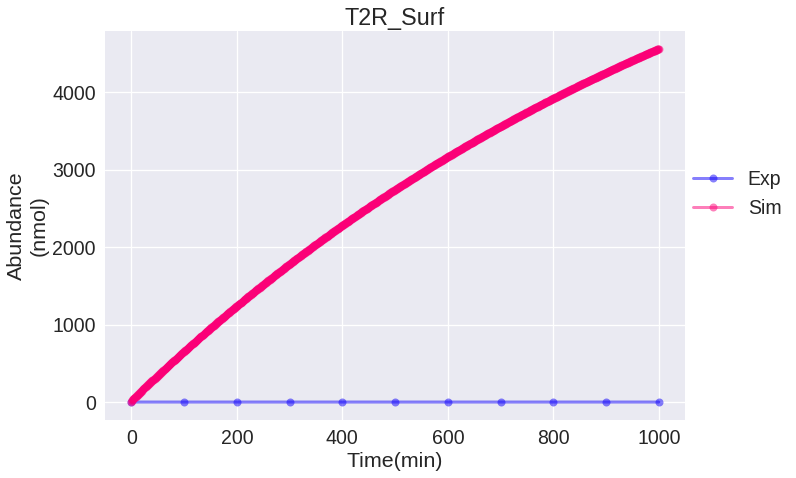

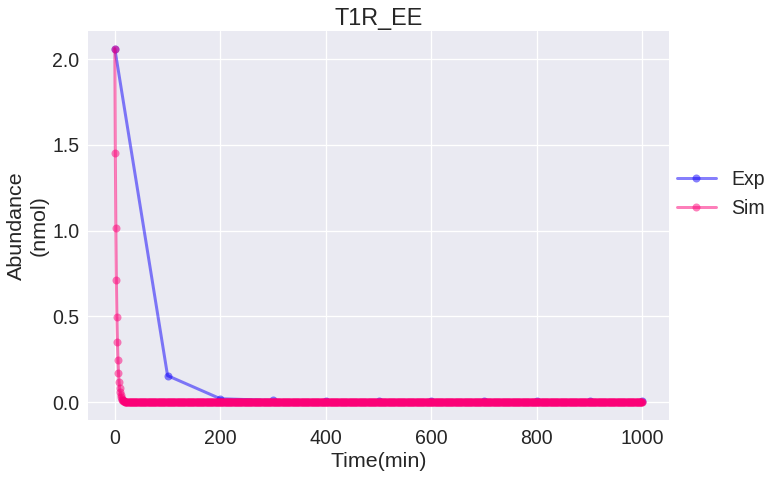

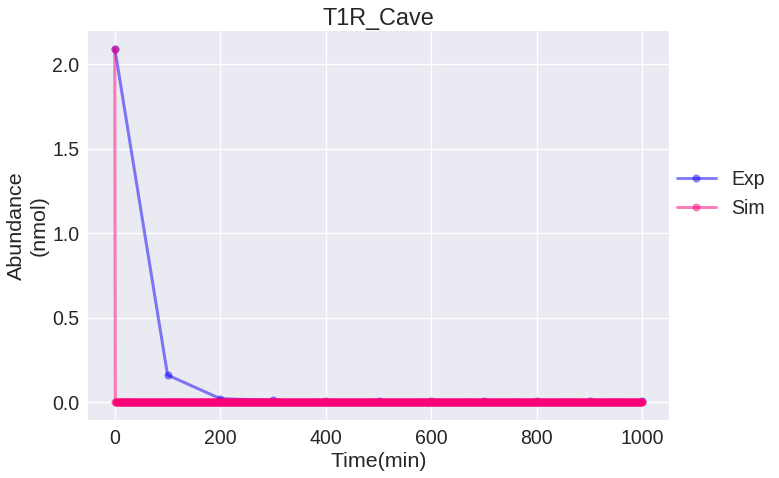

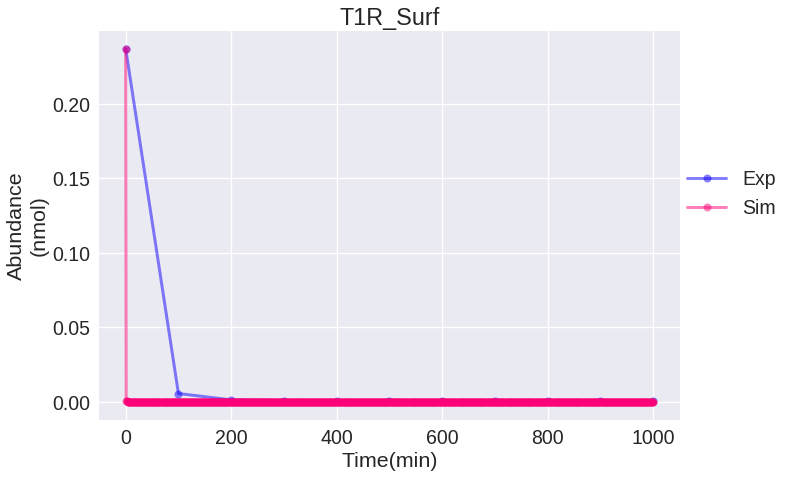

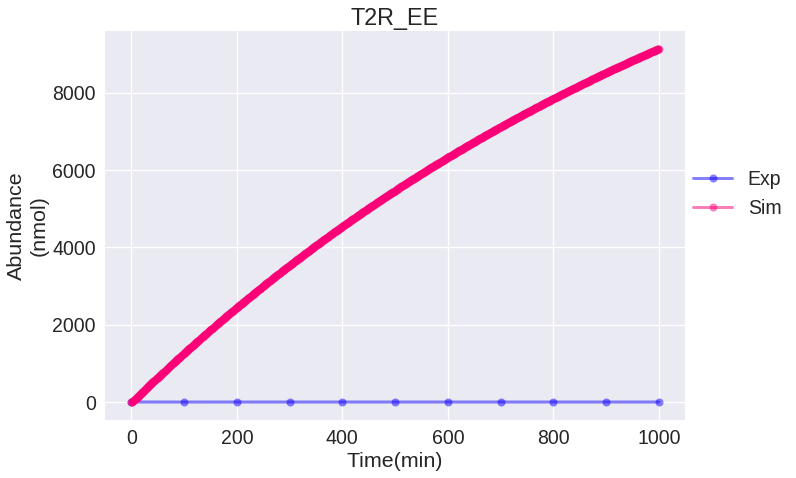

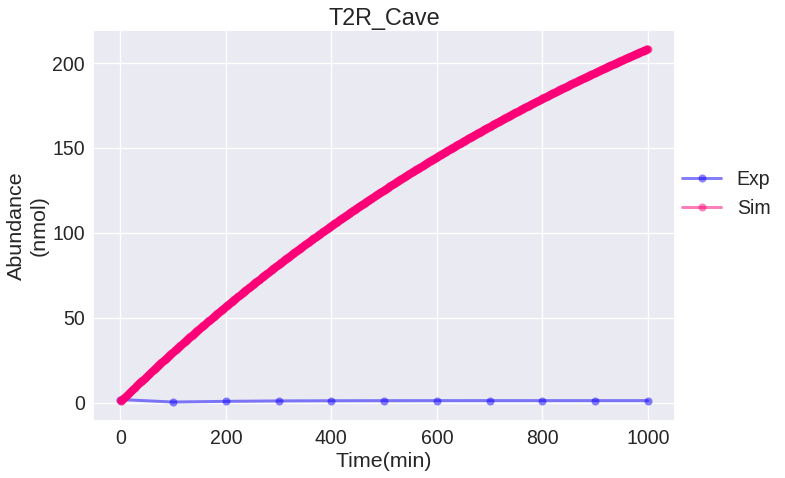

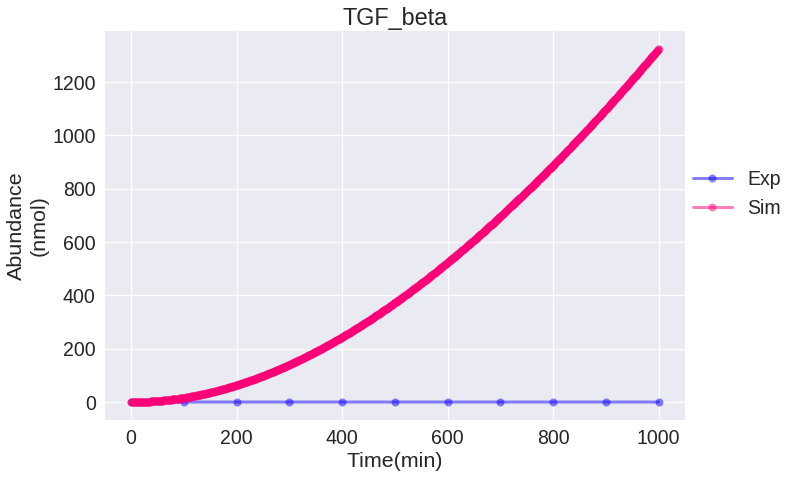

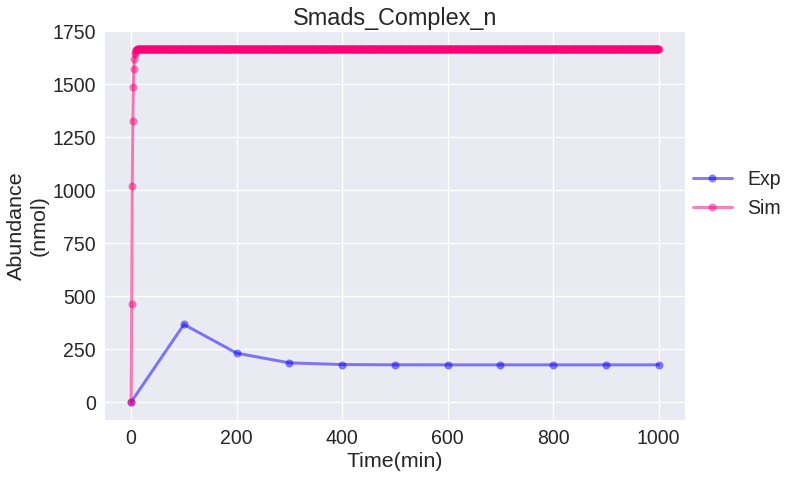

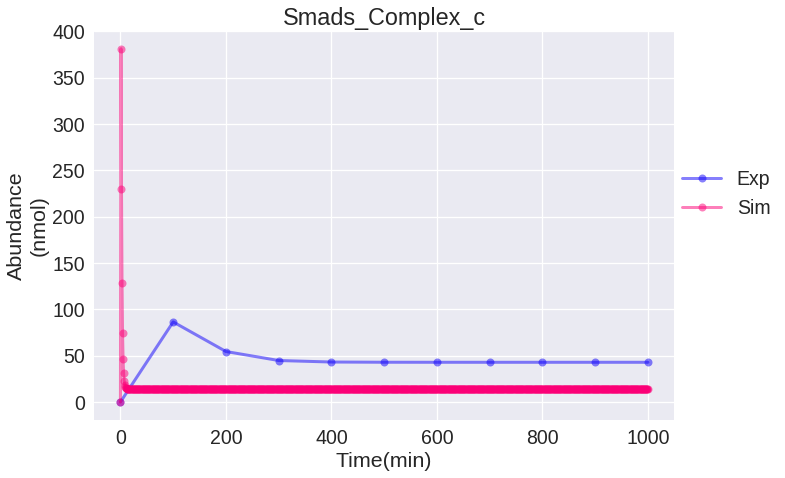

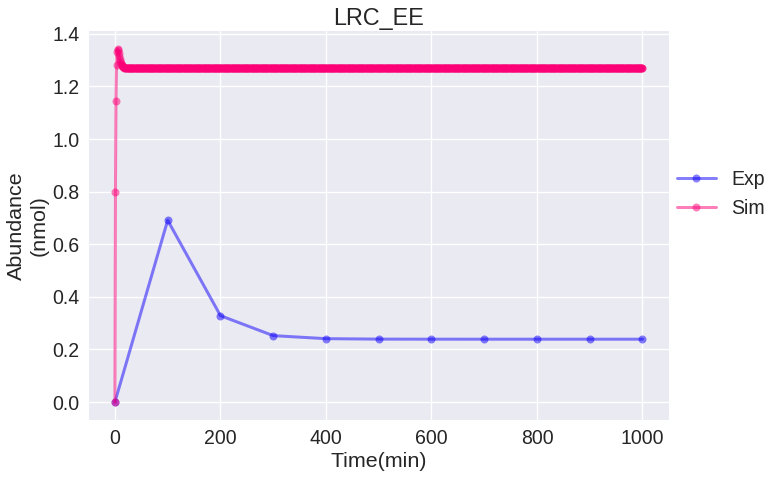

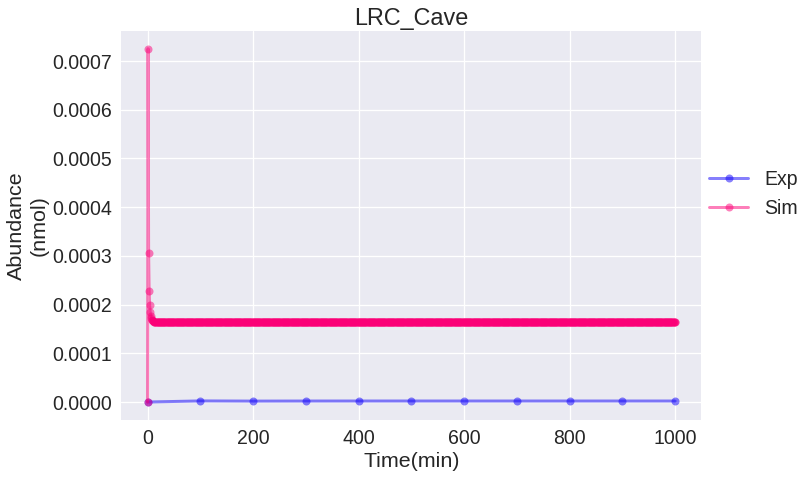

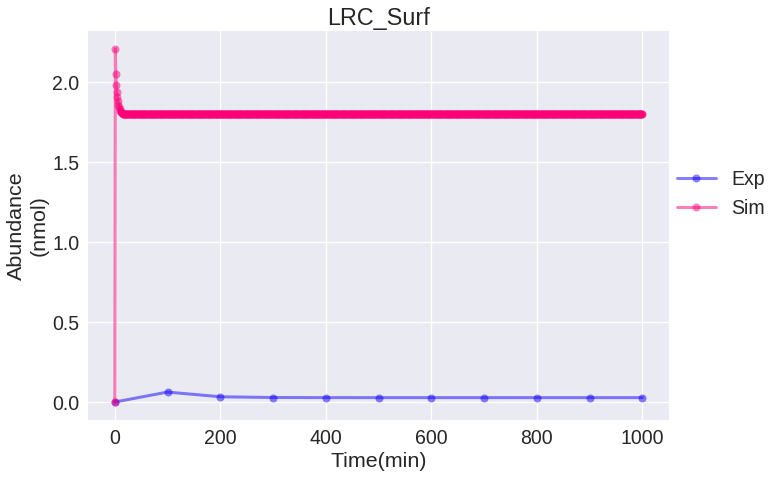

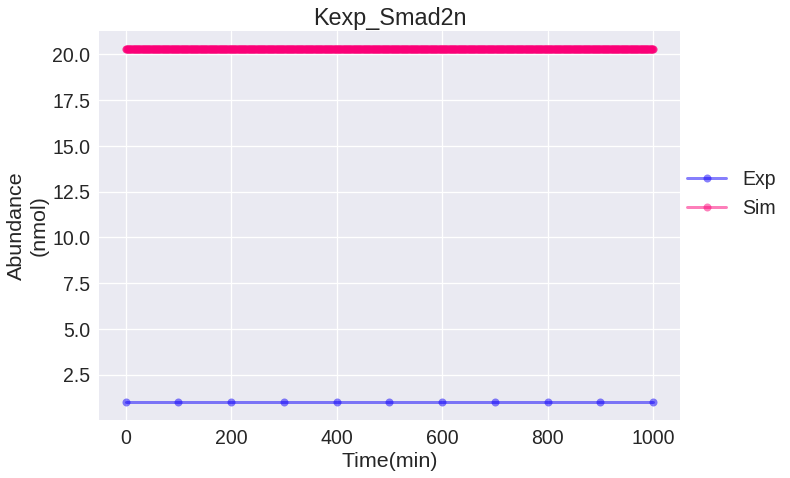

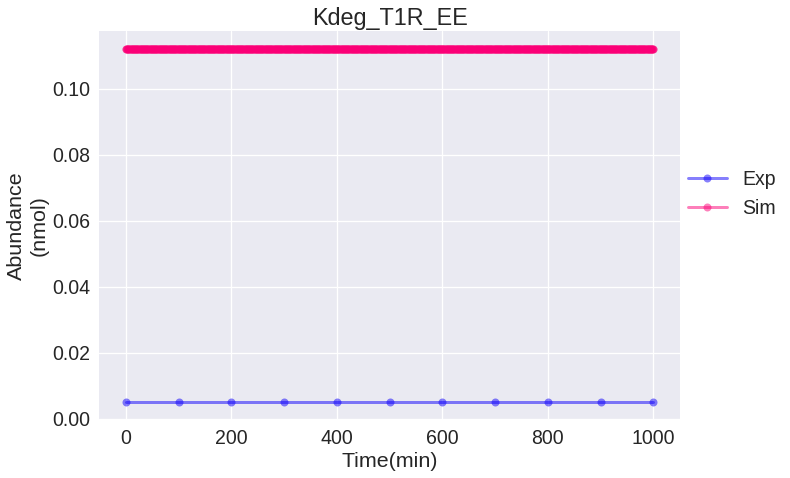

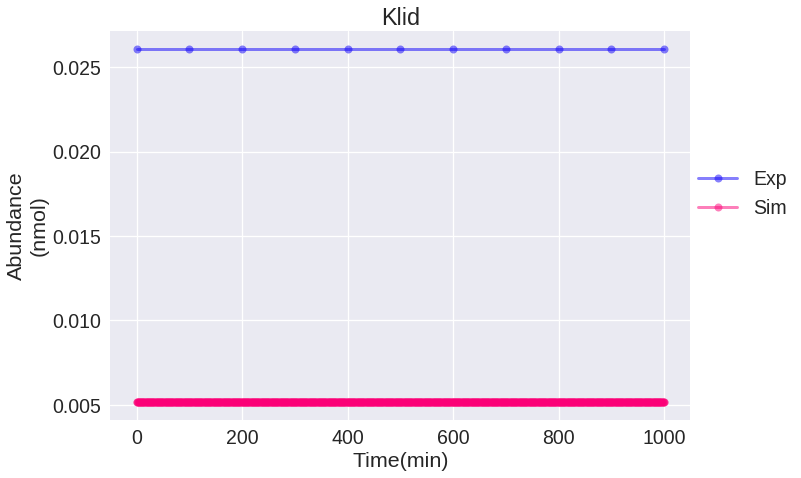

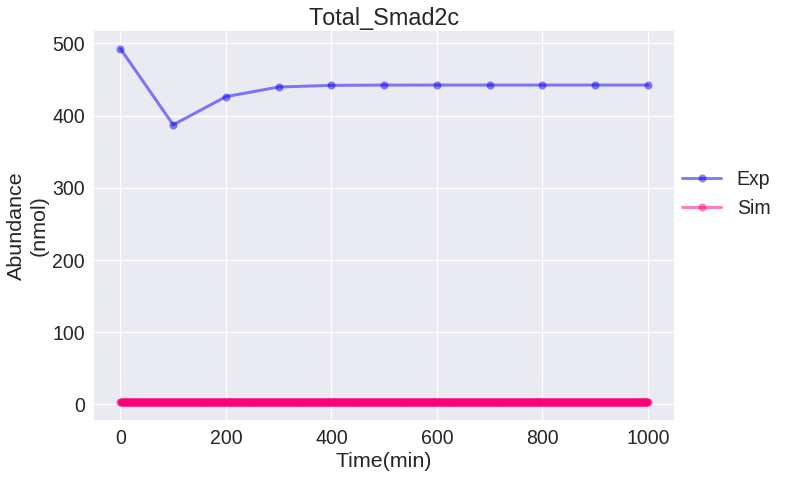

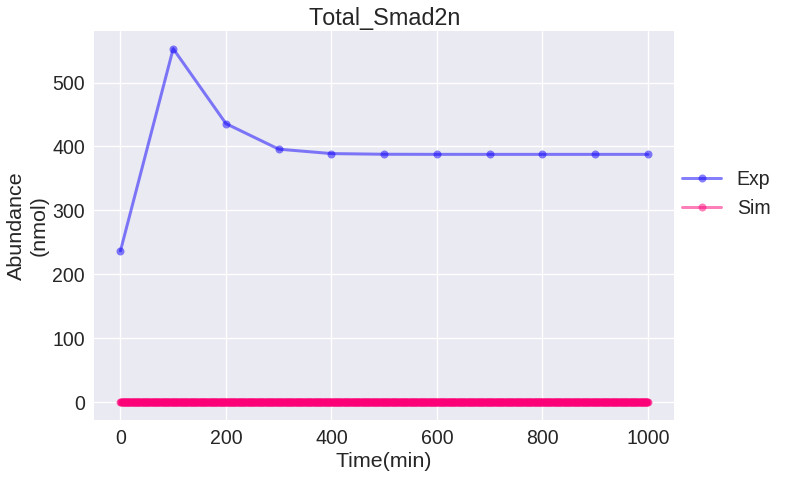

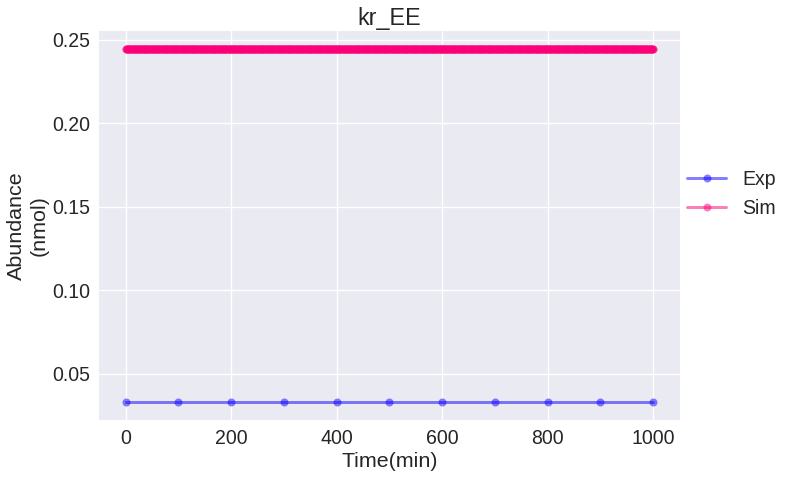

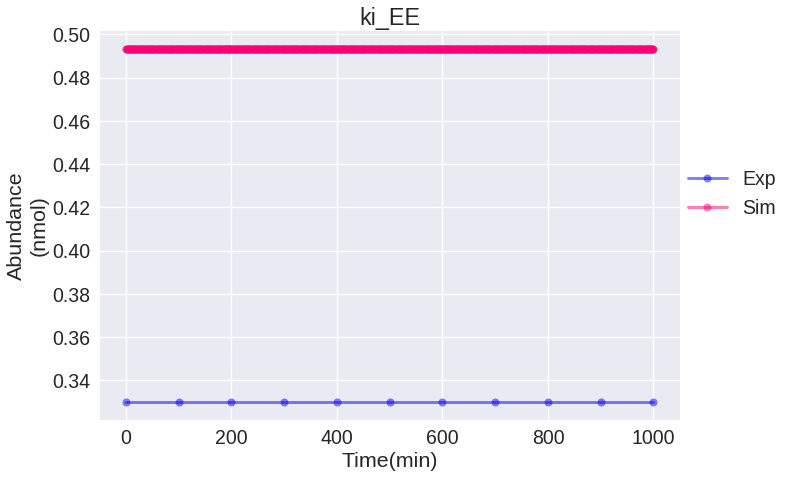

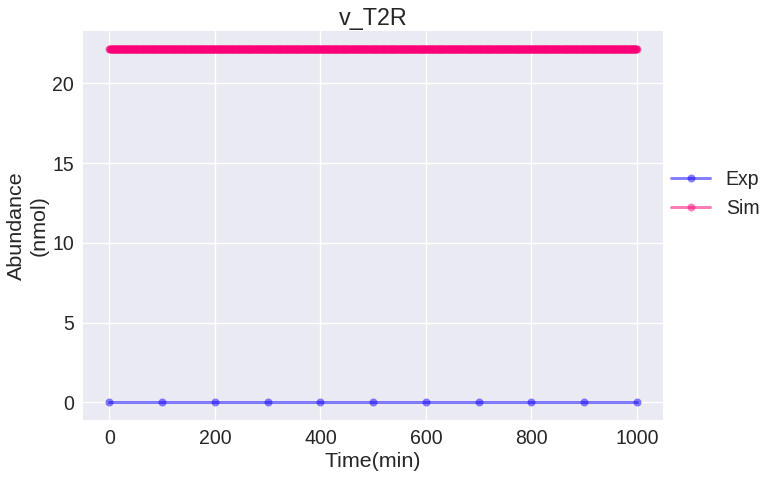

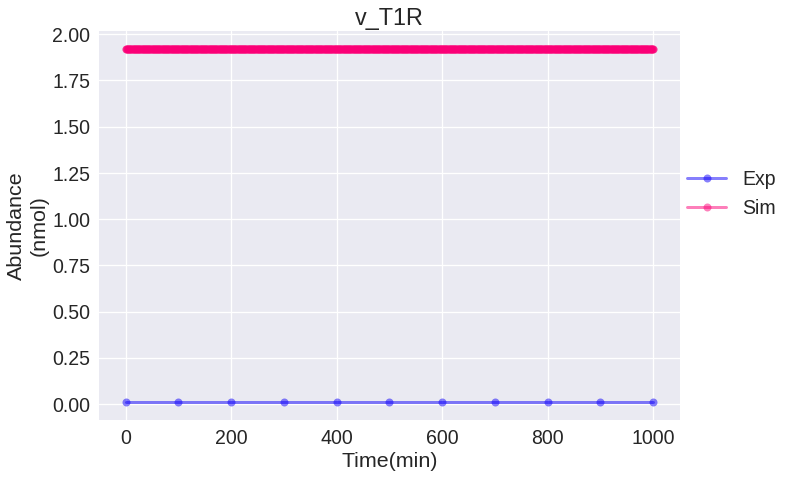

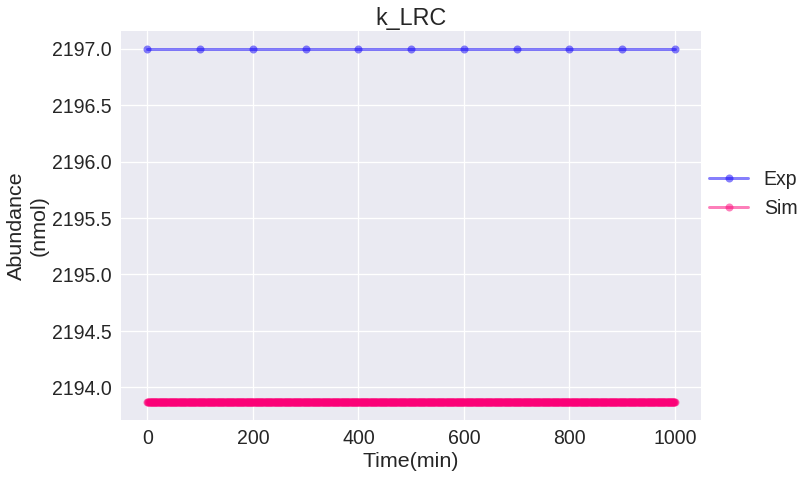

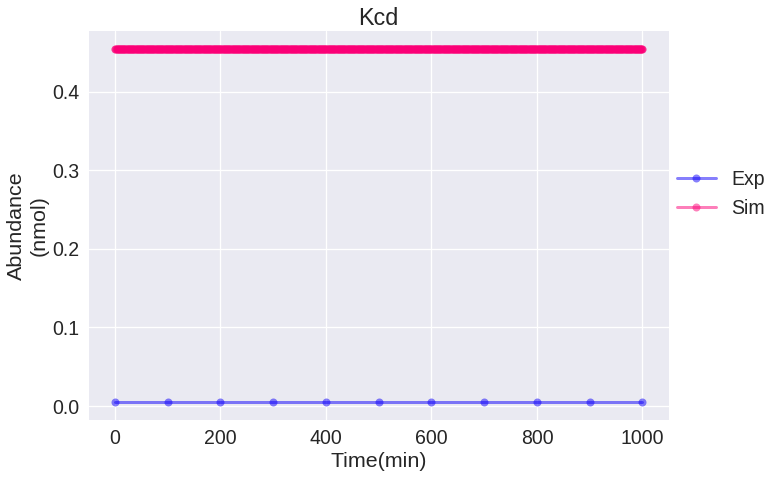

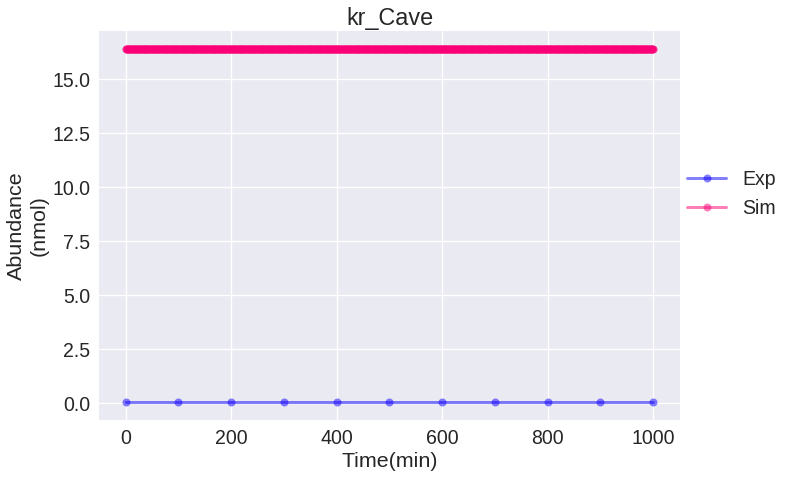

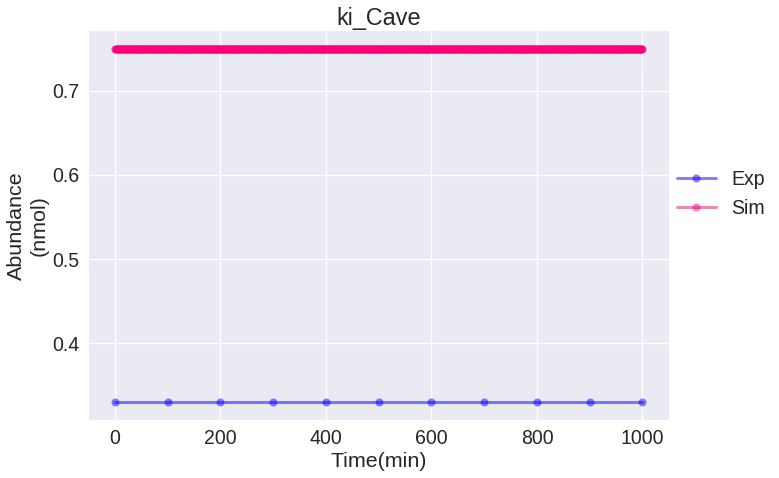

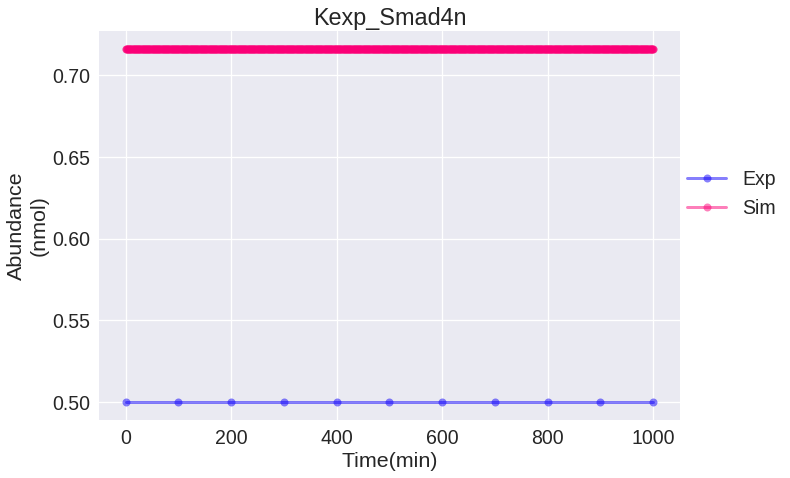

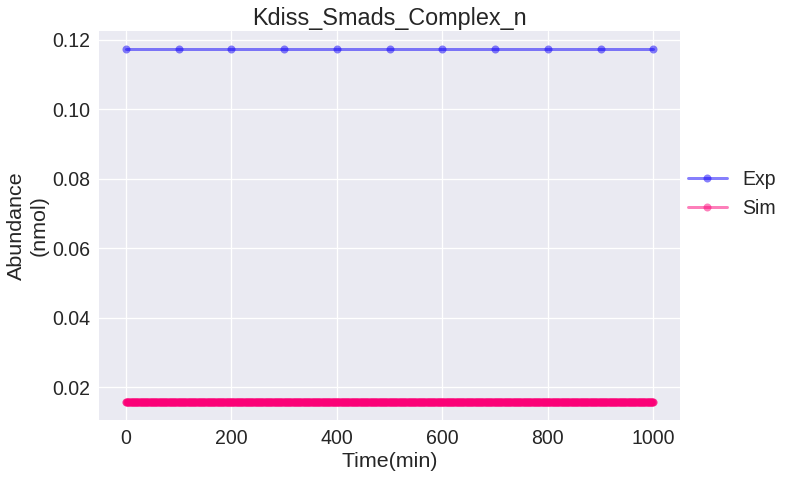

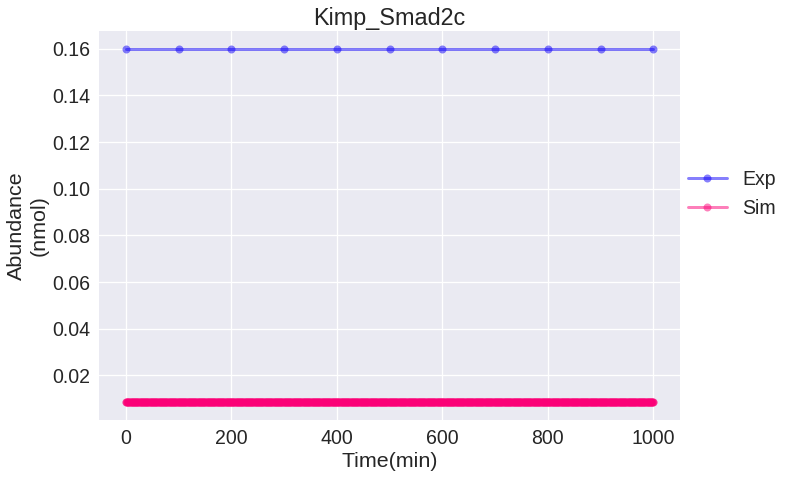

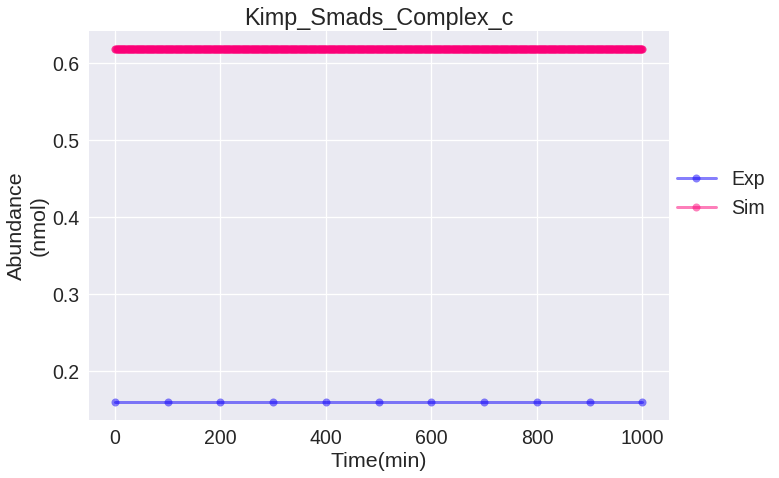

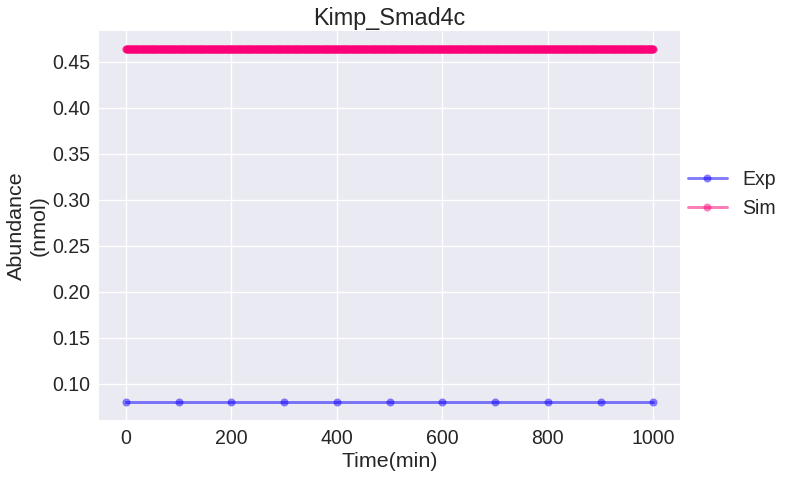

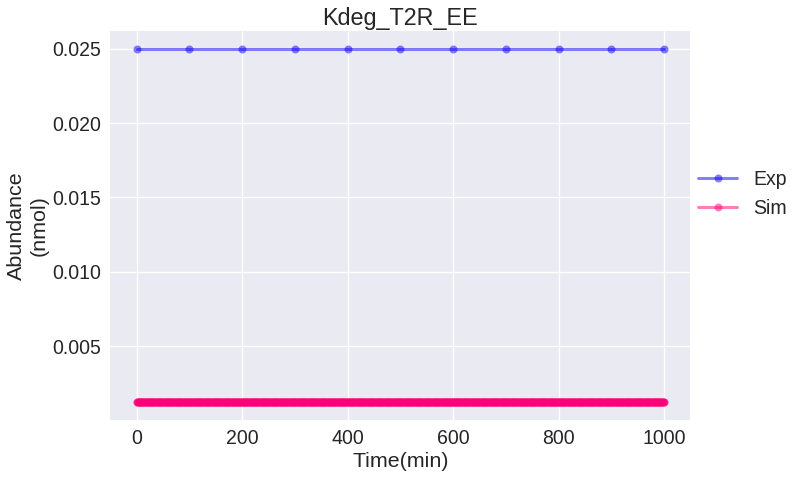

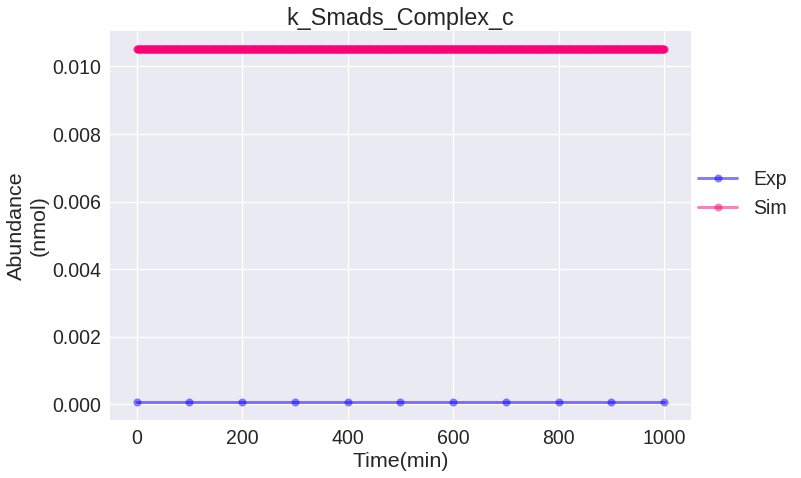

In [14]:
viz.PlotParameterEstimation(PE)

### Save to file (default options)

pycotools.viz:INFO:1659:    figure saved to "/home/b3053674/Documents/Models/2017/10_Oct/TutorialWorkspace/ParameterEstimationPlots/parameter_estimation_synthetic_data/Smad4n.png"
pycotools.viz:INFO:1659:    figure saved to "/home/b3053674/Documents/Models/2017/10_Oct/TutorialWorkspace/ParameterEstimationPlots/parameter_estimation_synthetic_data/Smad4c.png"
pycotools.viz:INFO:1659:    figure saved to "/home/b3053674/Documents/Models/2017/10_Oct/TutorialWorkspace/ParameterEstimationPlots/parameter_estimation_synthetic_data/Smad3n.png"
pycotools.viz:INFO:1659:    figure saved to "/home/b3053674/Documents/Models/2017/10_Oct/TutorialWorkspace/ParameterEstimationPlots/parameter_estimation_synthetic_data/Smad3c.png"
pycotools.viz:INFO:1659:    figure saved to "/home/b3053674/Documents/Models/2017/10_Oct/TutorialWorkspace/ParameterEstimationPlots/parameter_estimation_synthetic_data/T2R_Surf.png"
pycotools.viz:INFO:1659:    figure saved to "/home/b3053674/Documents/Models/2017/10_Oct/TutorialW

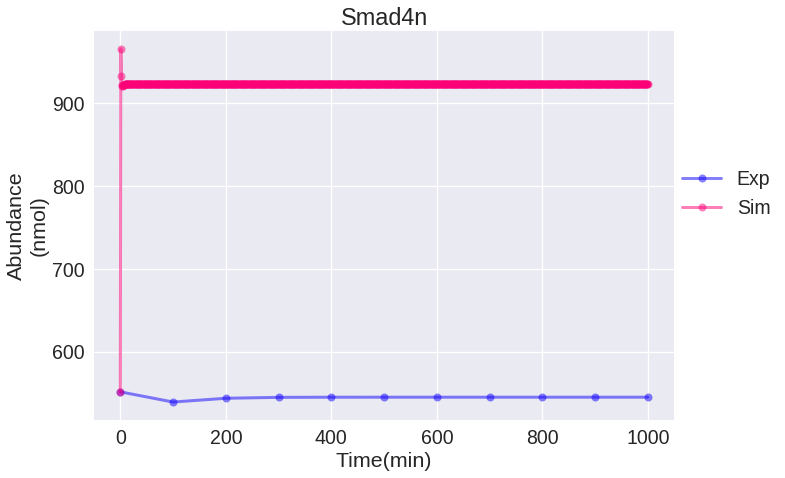

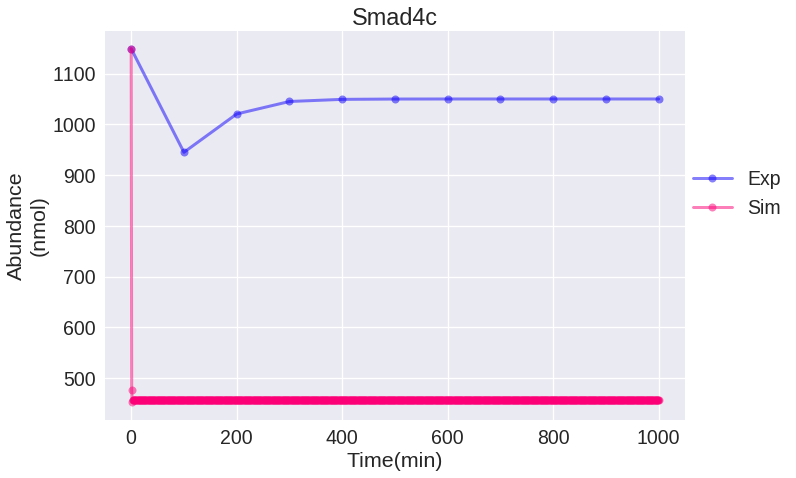

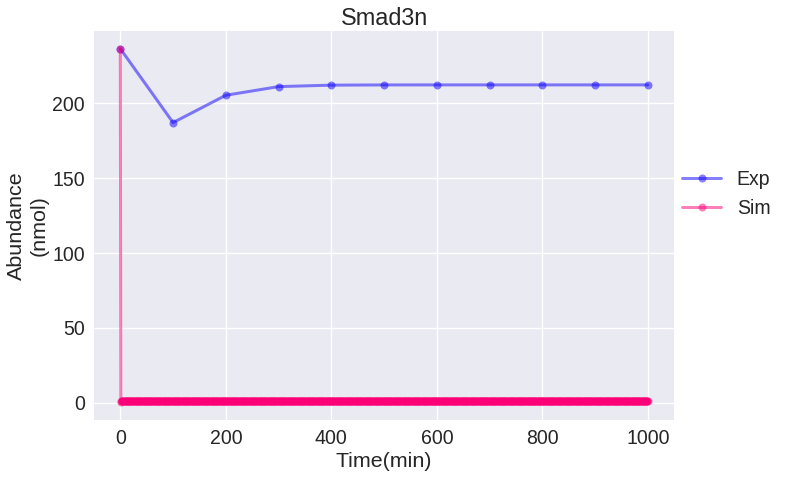

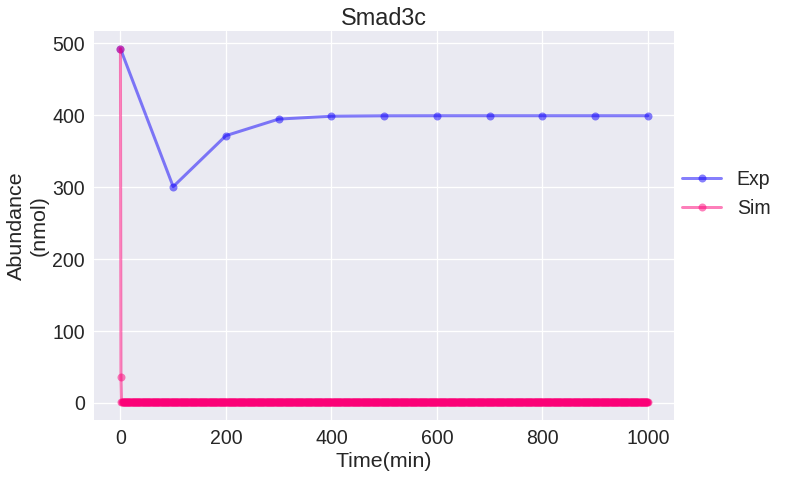

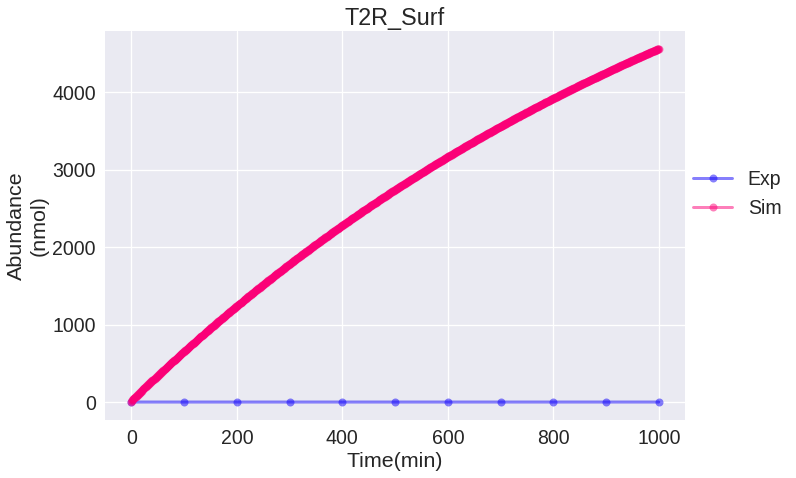

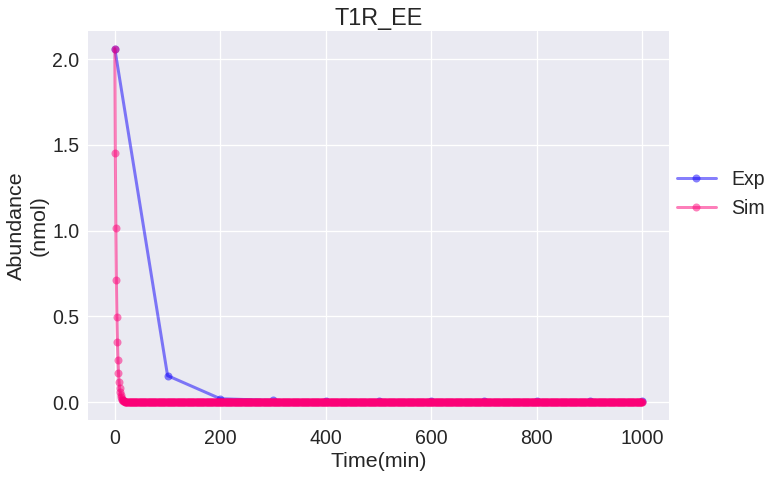

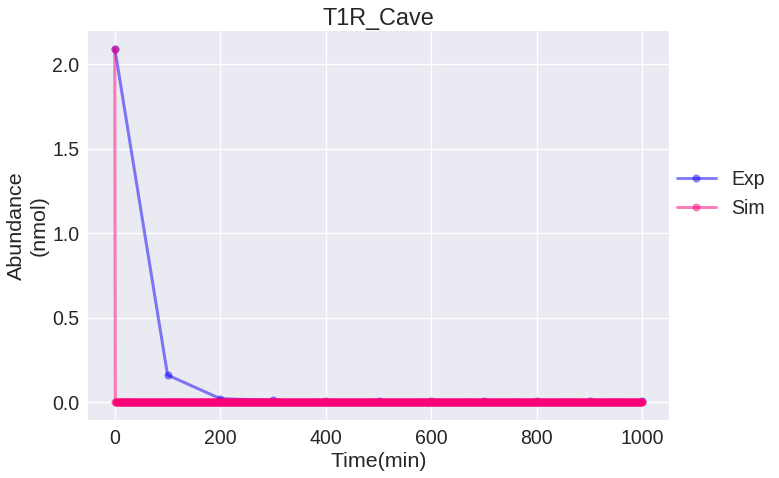

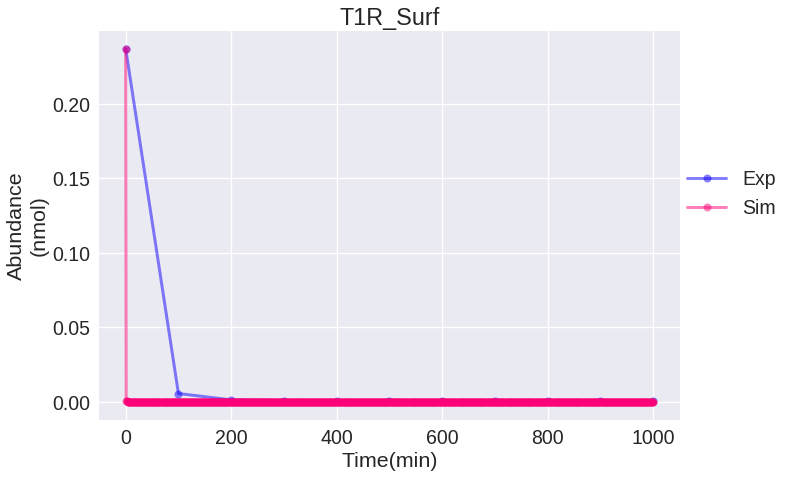

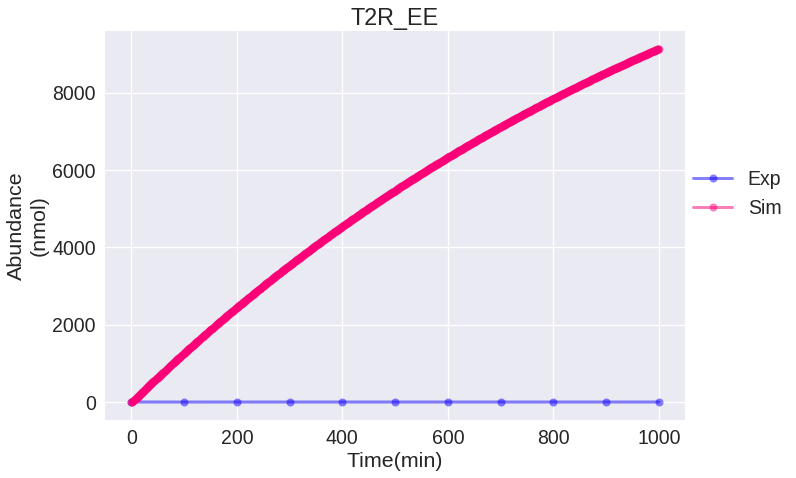

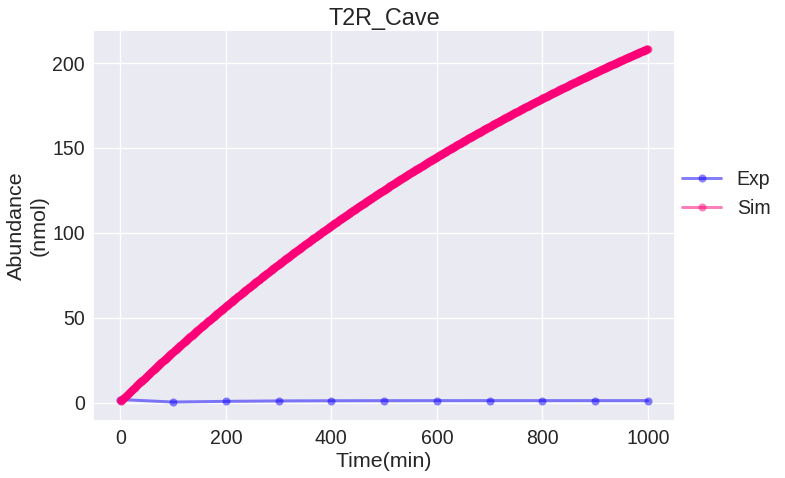

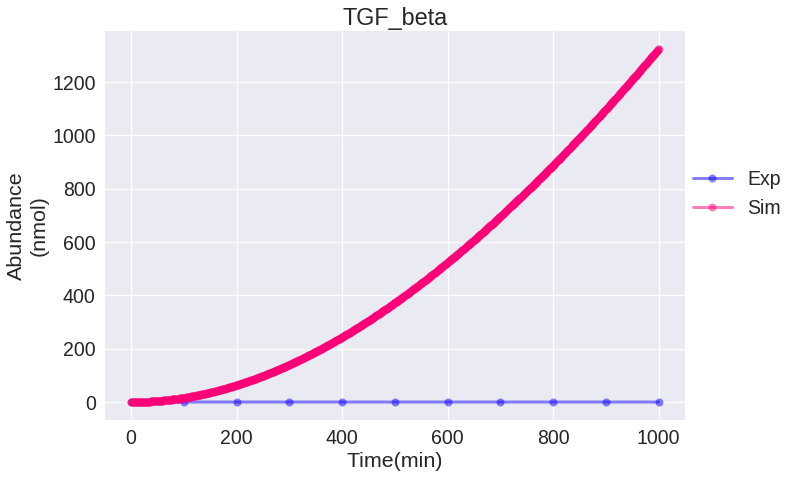

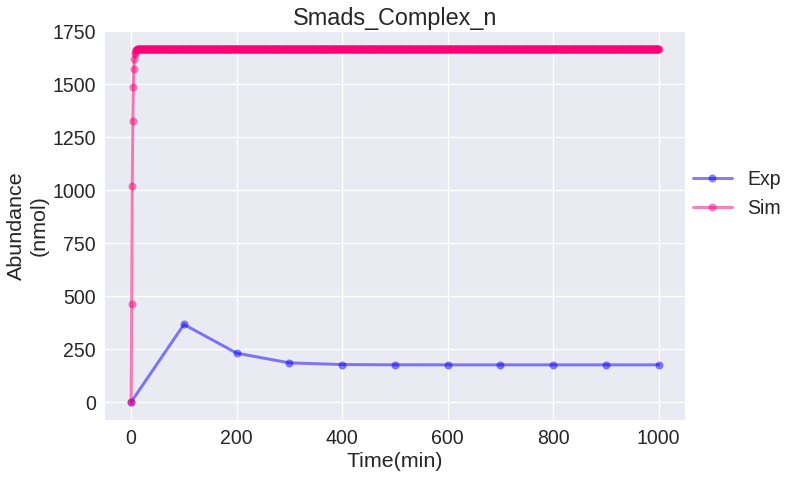

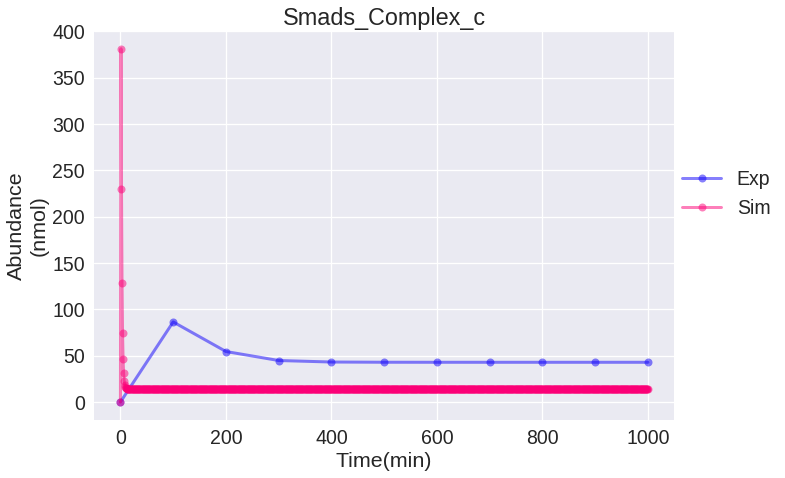

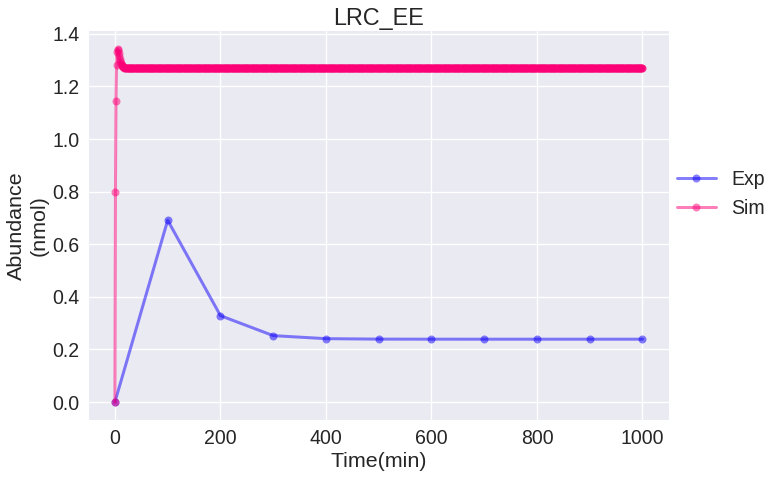

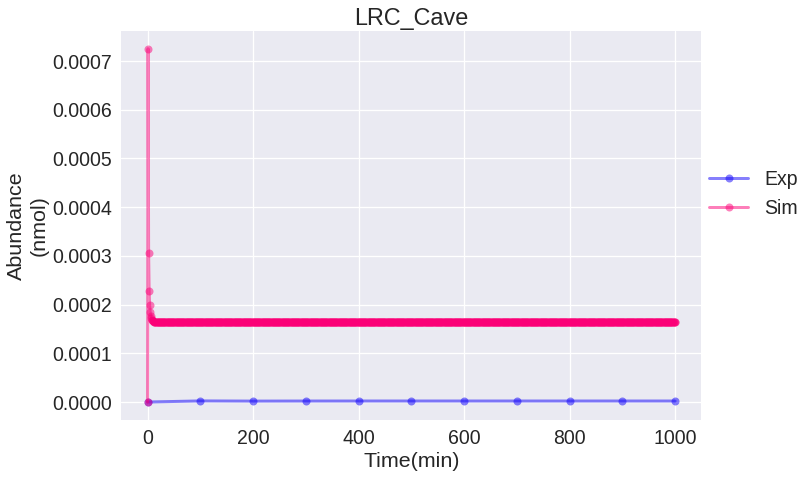

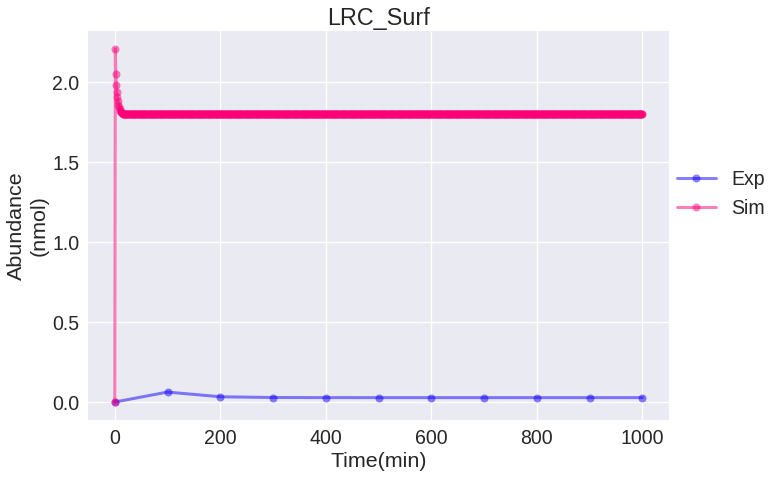

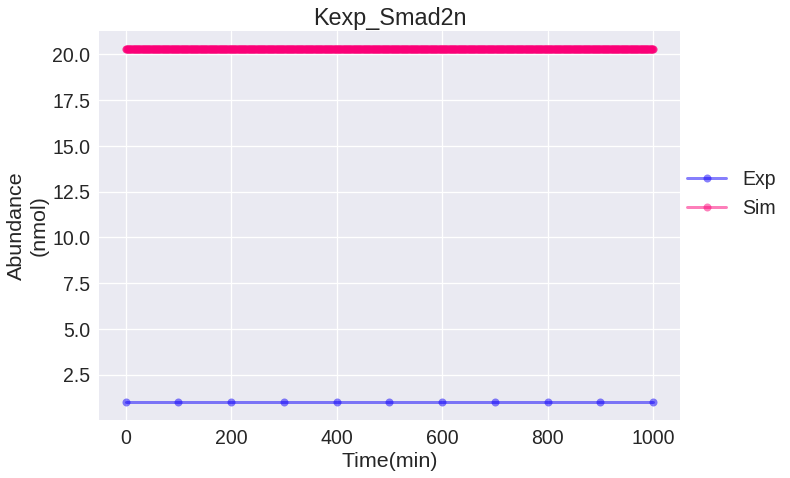

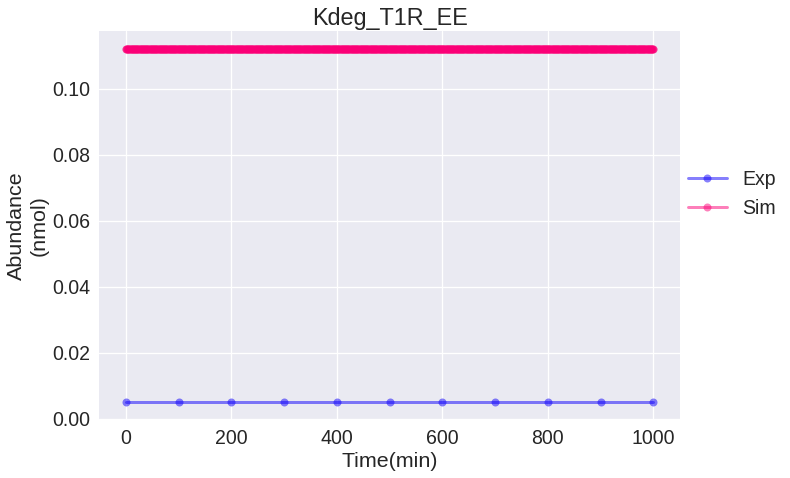

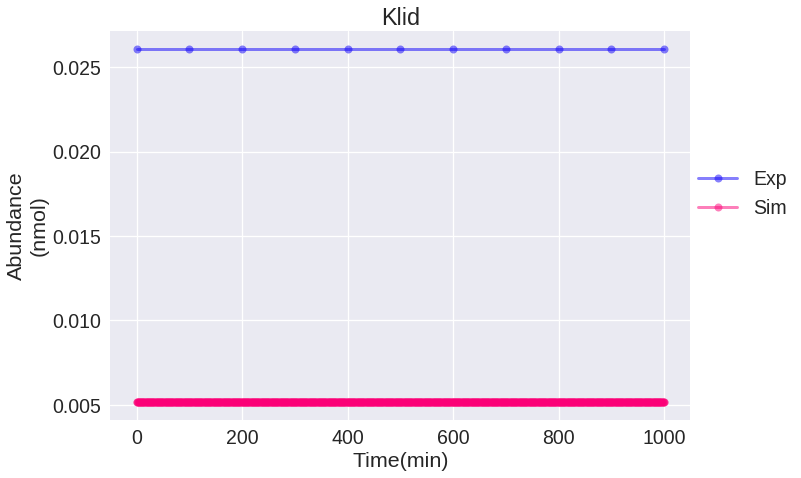

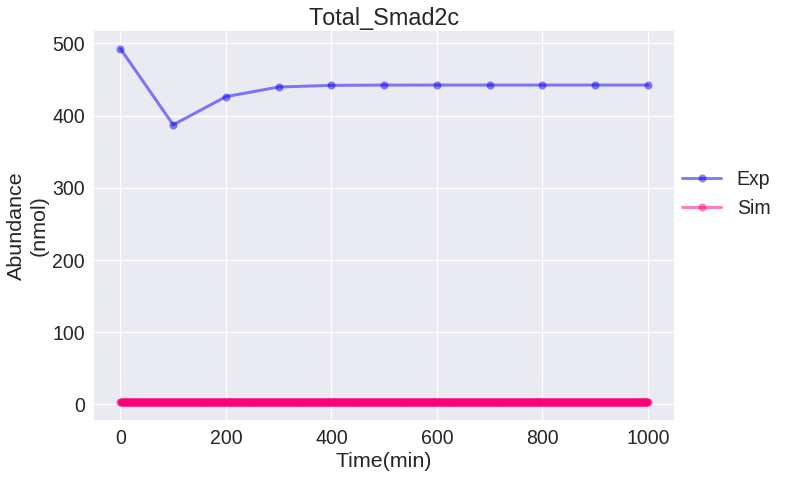

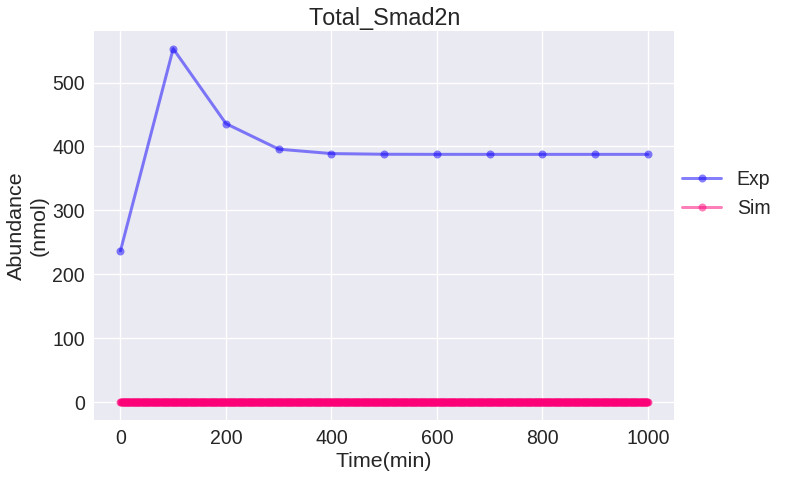

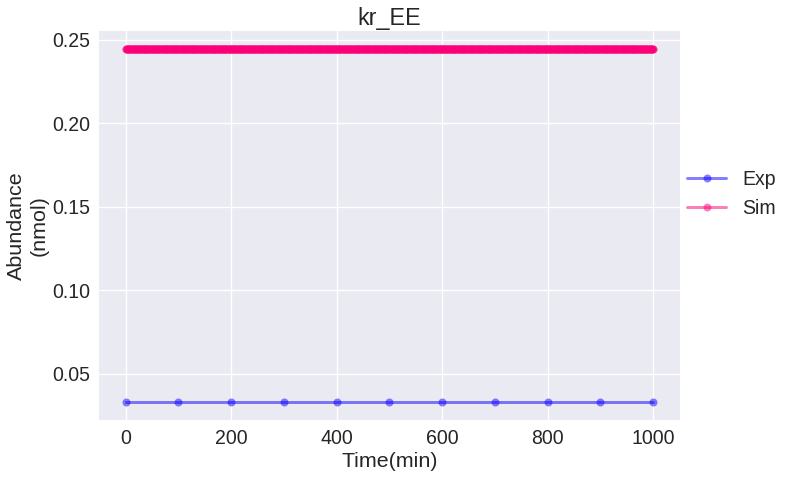

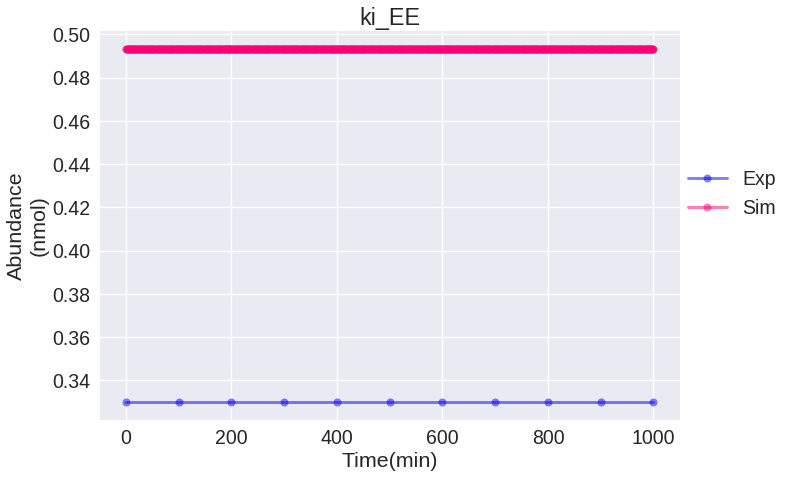

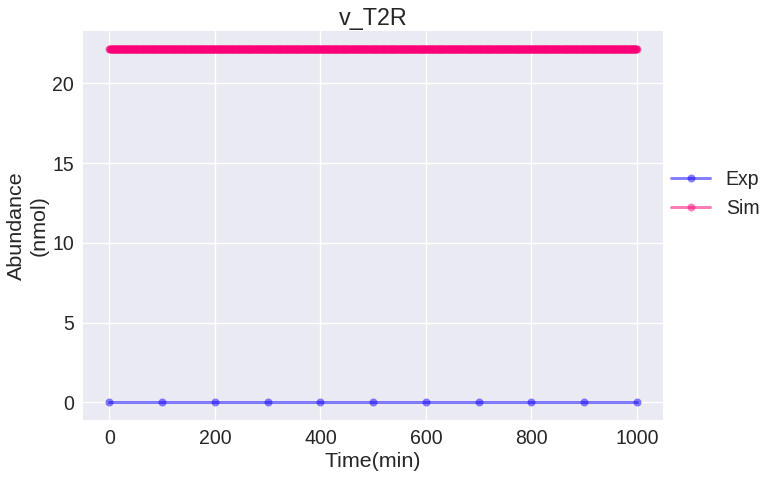

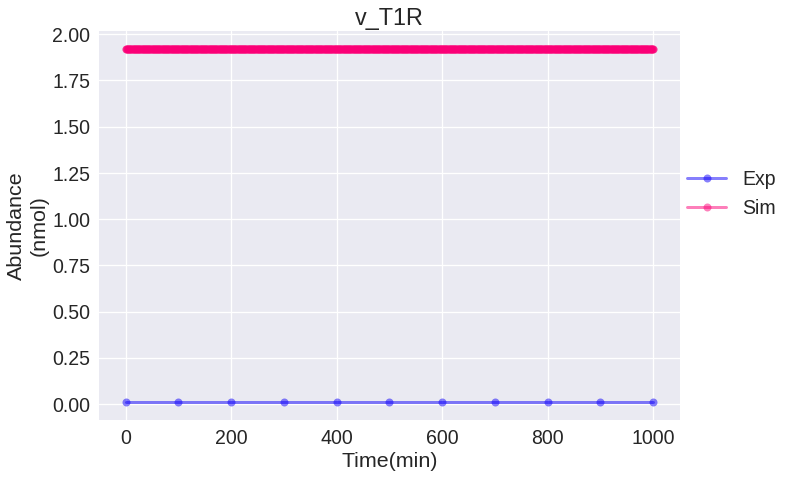

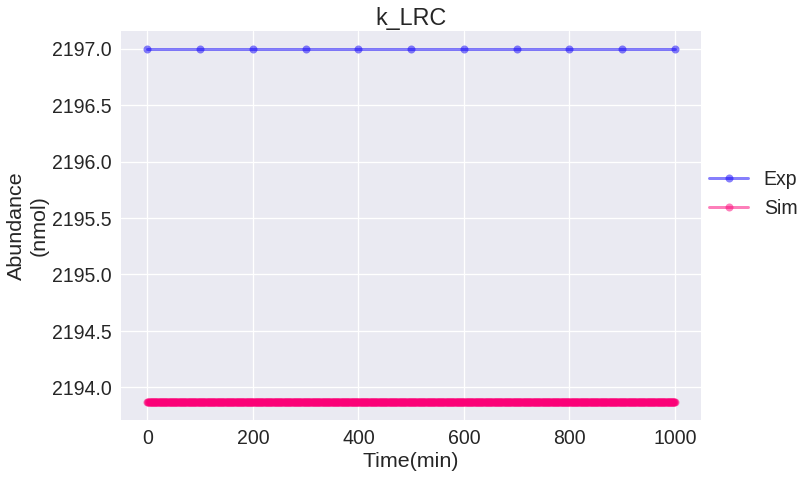

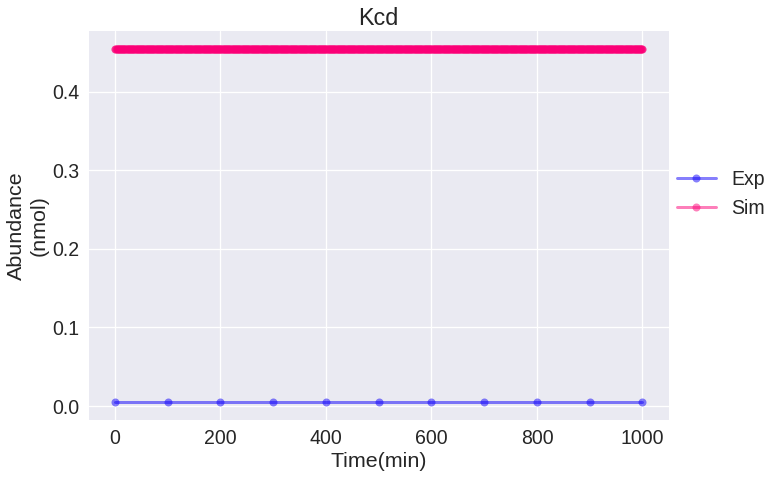

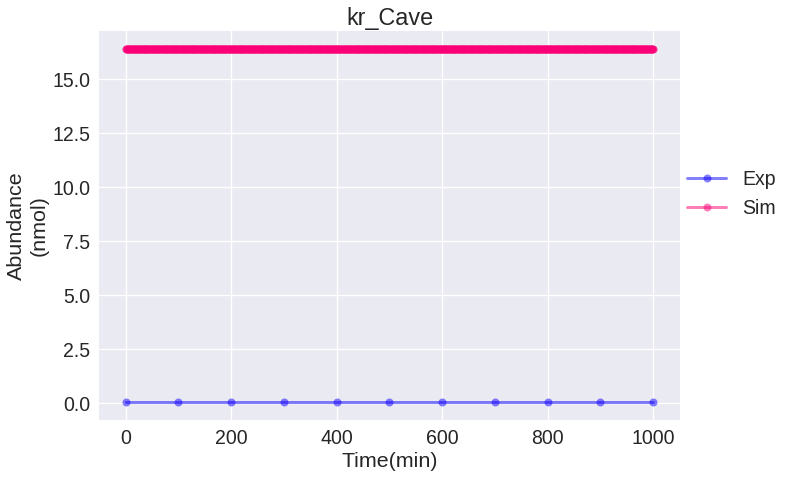

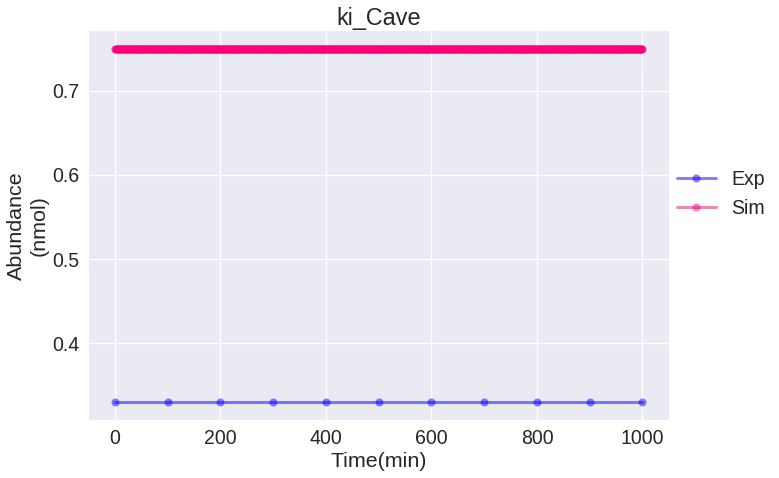

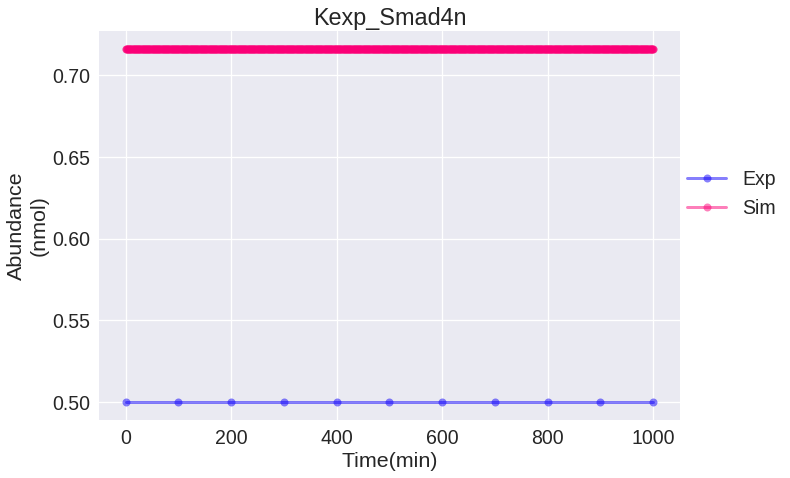

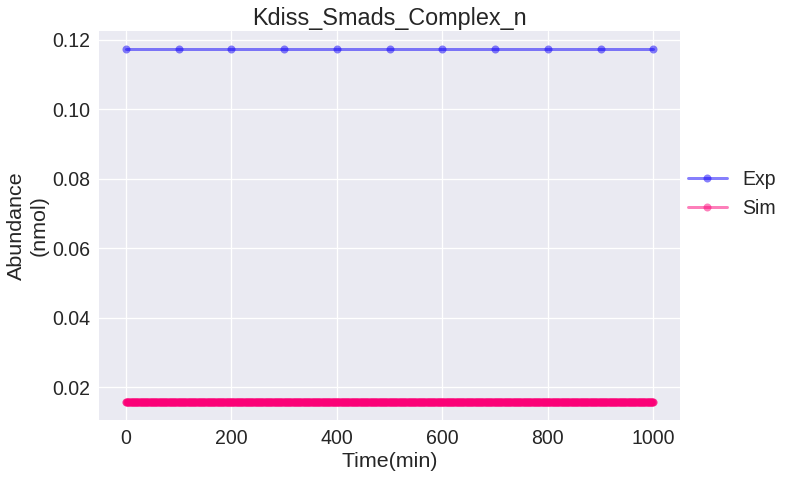

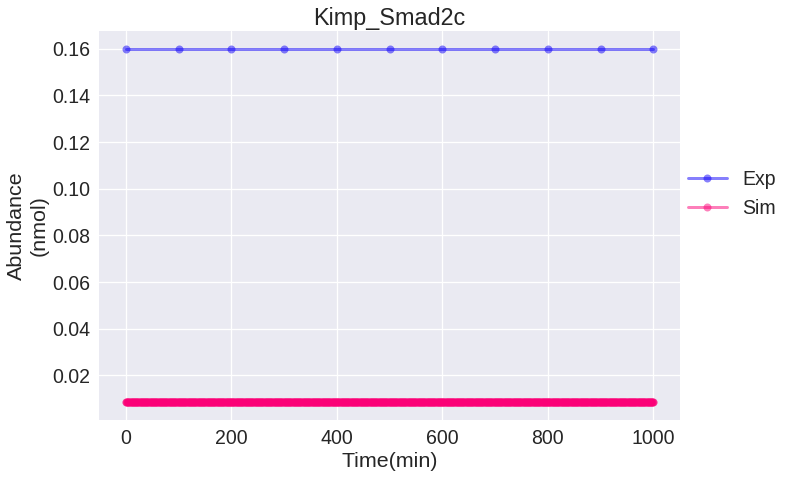

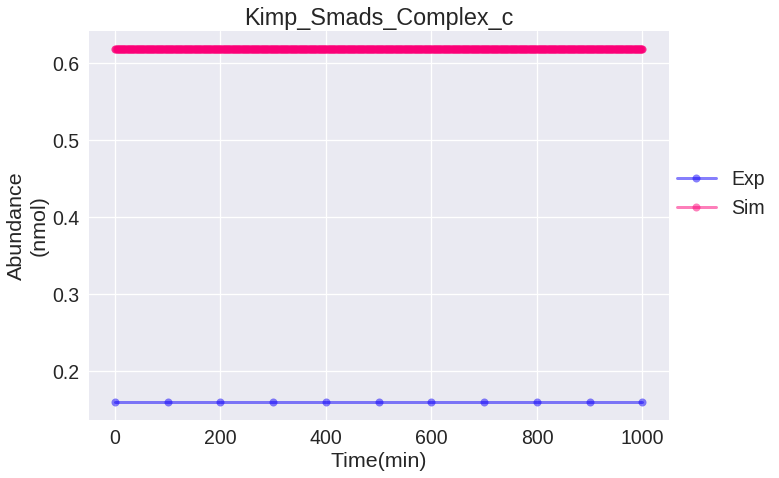

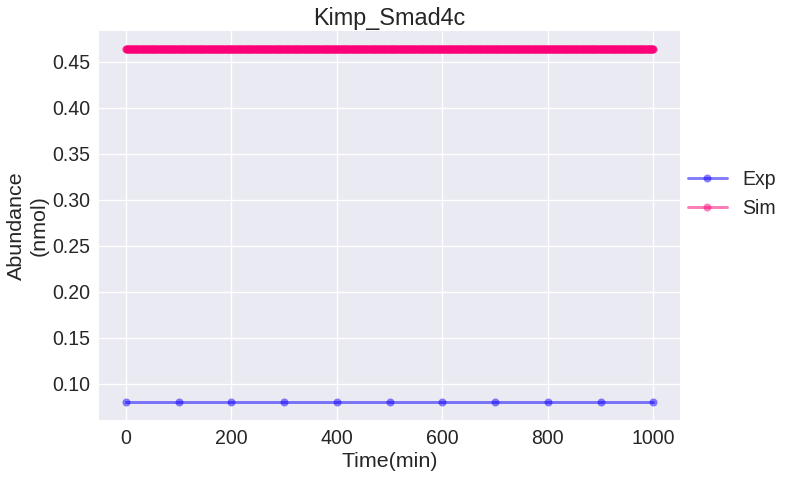

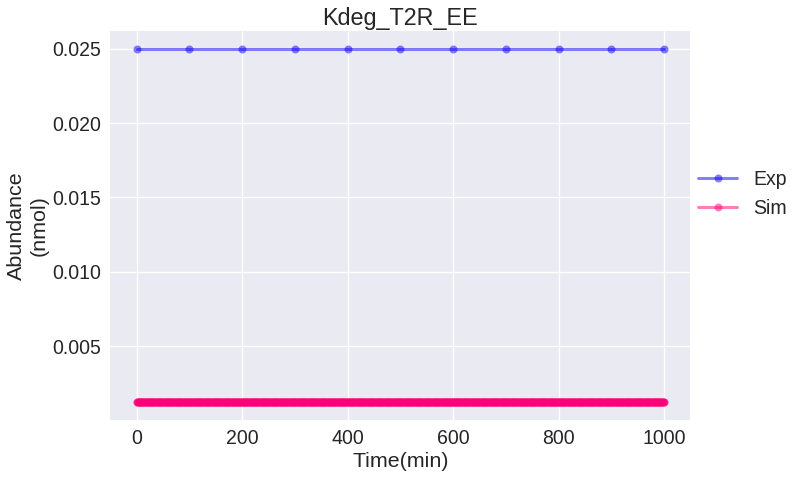

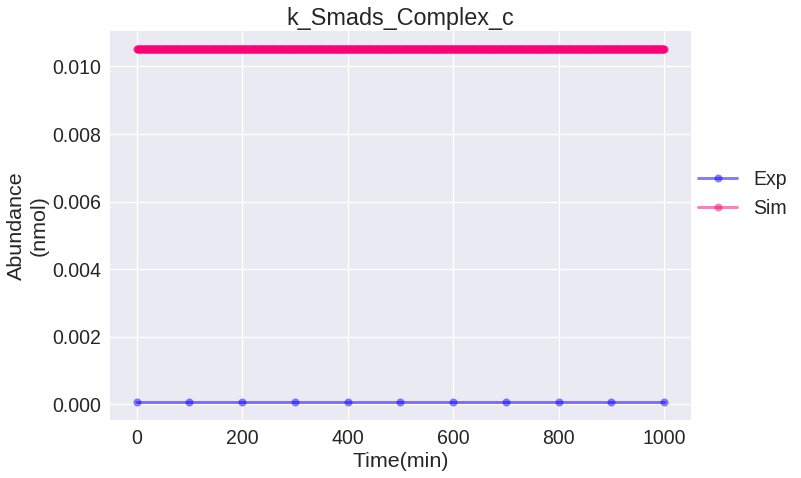

In [15]:
viz.PlotParameterEstimation(PE, savefig=True)

### Save to file (user specified options)

pycotools.viz:INFO:1659:    figure saved to "MyParameterEstimationResults/parameter_estimation_synthetic_data/Smad4n.png"
pycotools.viz:INFO:1659:    figure saved to "MyParameterEstimationResults/parameter_estimation_synthetic_data/Smad4c.png"
pycotools.viz:INFO:1659:    figure saved to "MyParameterEstimationResults/parameter_estimation_synthetic_data/Smad3n.png"
pycotools.viz:INFO:1659:    figure saved to "MyParameterEstimationResults/parameter_estimation_synthetic_data/Smad3c.png"
pycotools.viz:INFO:1659:    figure saved to "MyParameterEstimationResults/parameter_estimation_synthetic_data/T2R_Surf.png"
pycotools.viz:INFO:1659:    figure saved to "MyParameterEstimationResults/parameter_estimation_synthetic_data/T1R_EE.png"
pycotools.viz:INFO:1659:    figure saved to "MyParameterEstimationResults/parameter_estimation_synthetic_data/T1R_Cave.png"
pycotools.viz:INFO:1659:    figure saved to "MyParameterEstimationResults/parameter_estimation_synthetic_data/T1R_Surf.png"
pycotools.viz:INFO

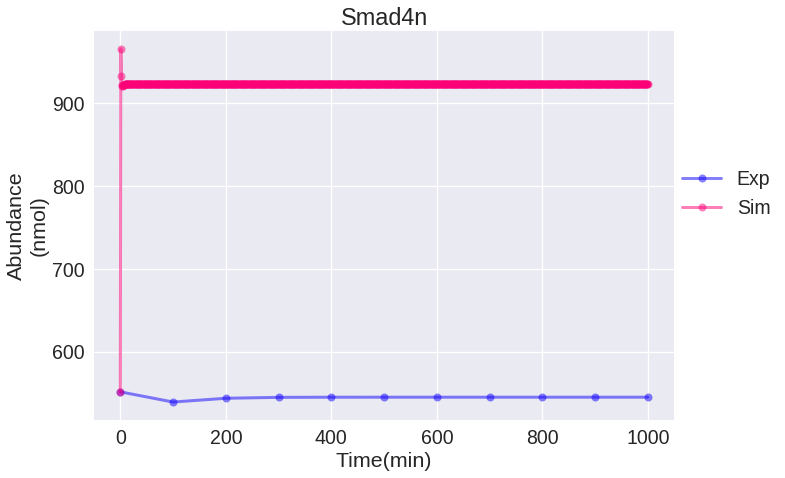

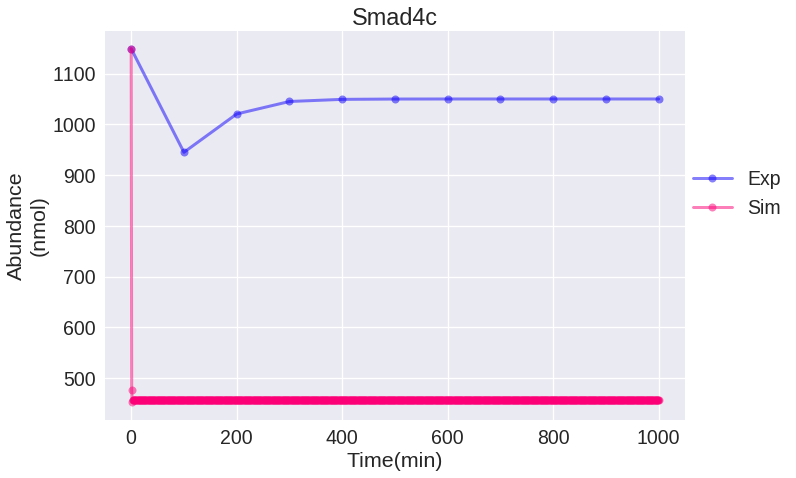

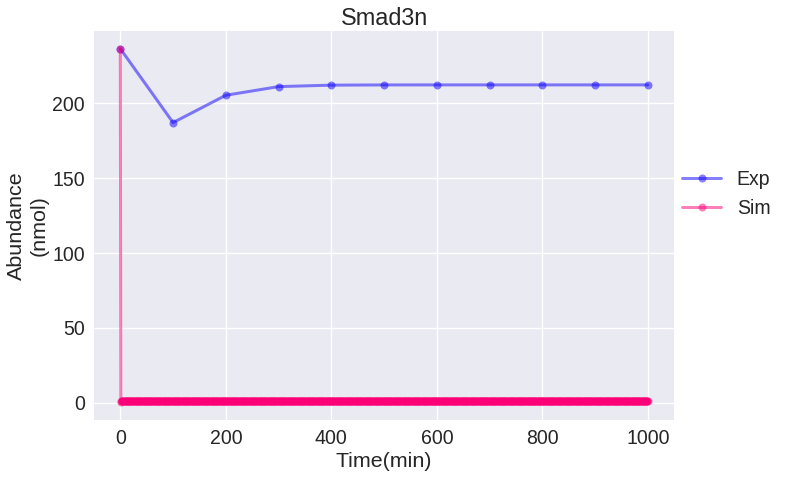

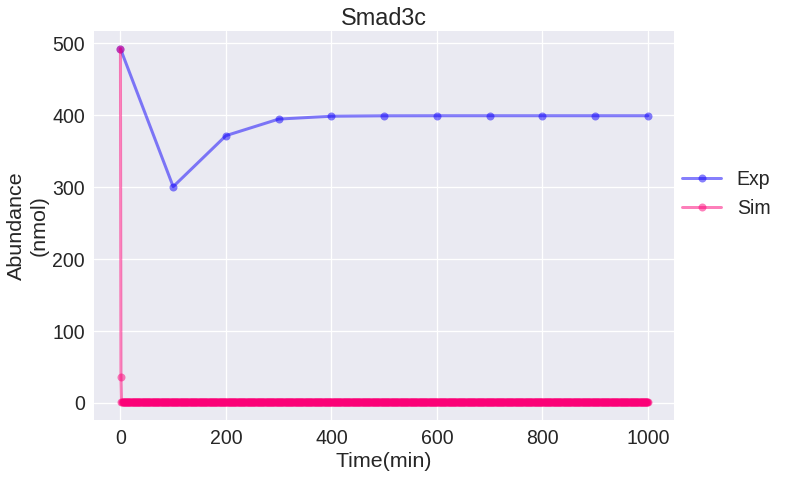

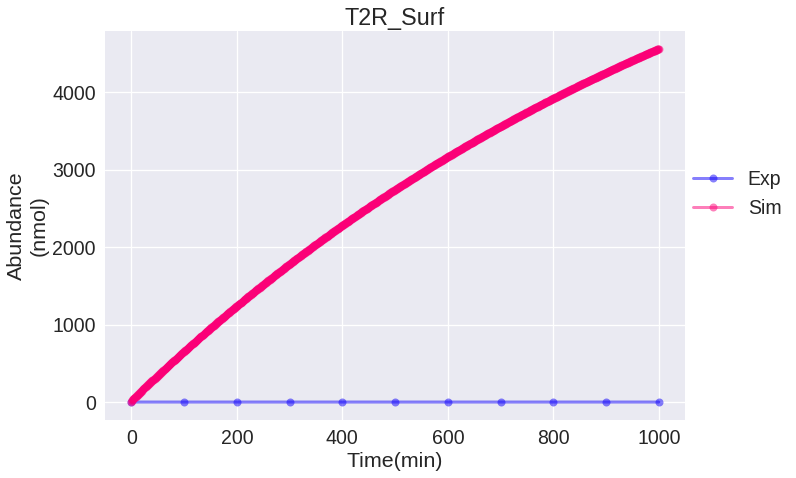

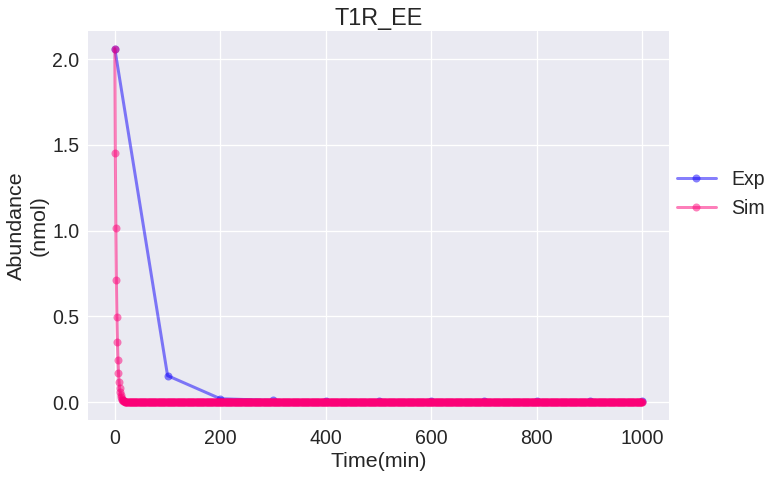

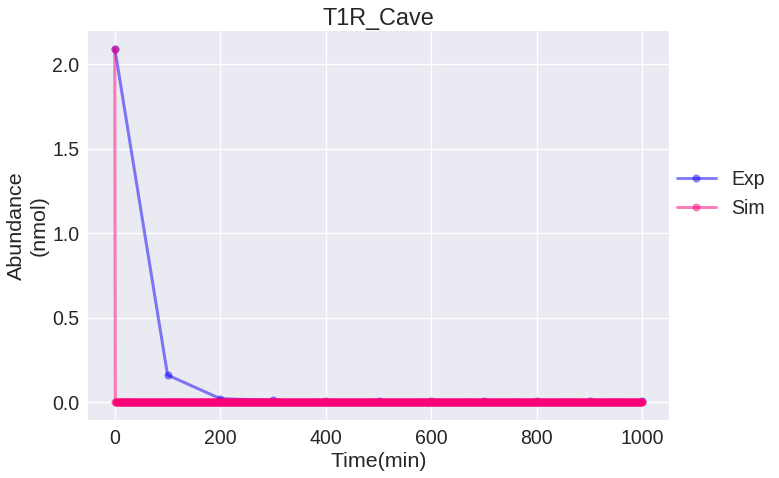

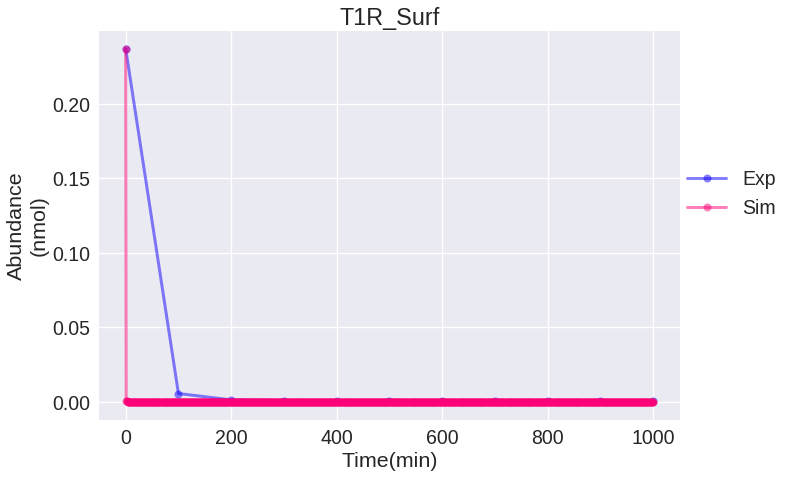

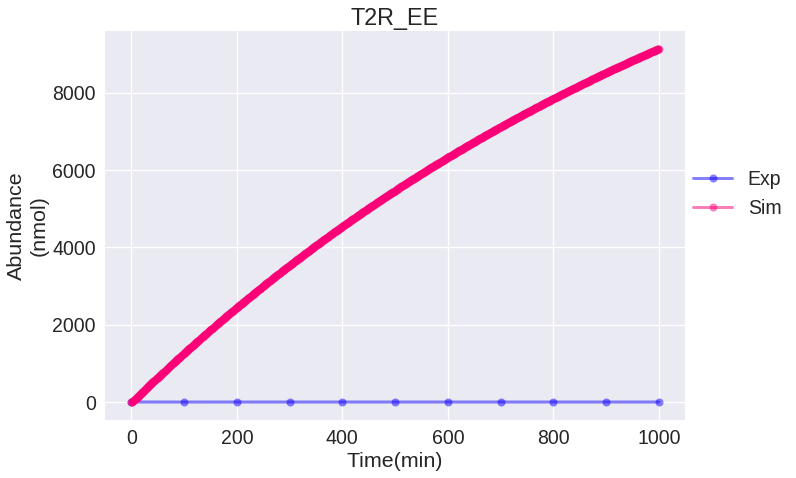

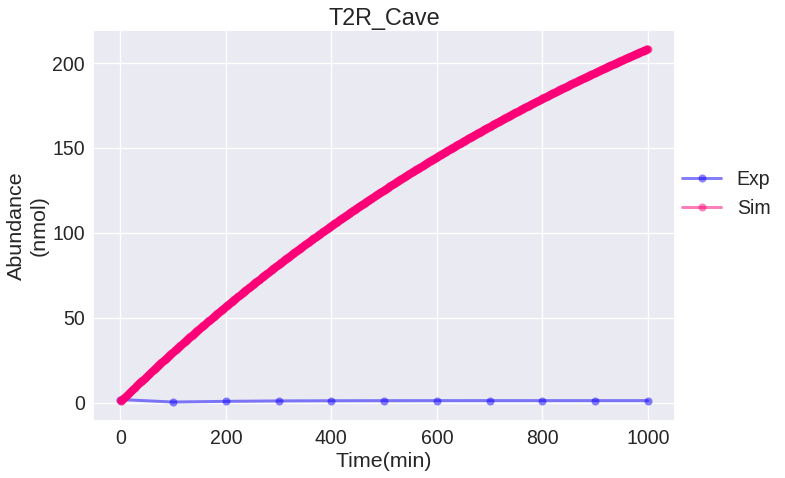

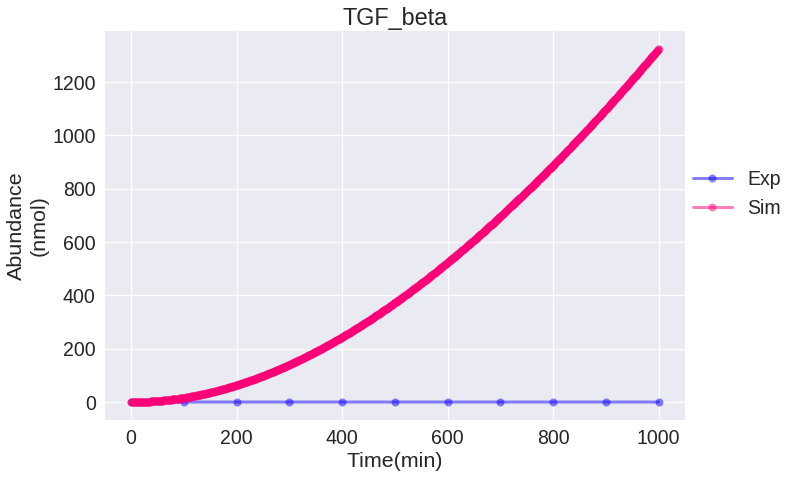

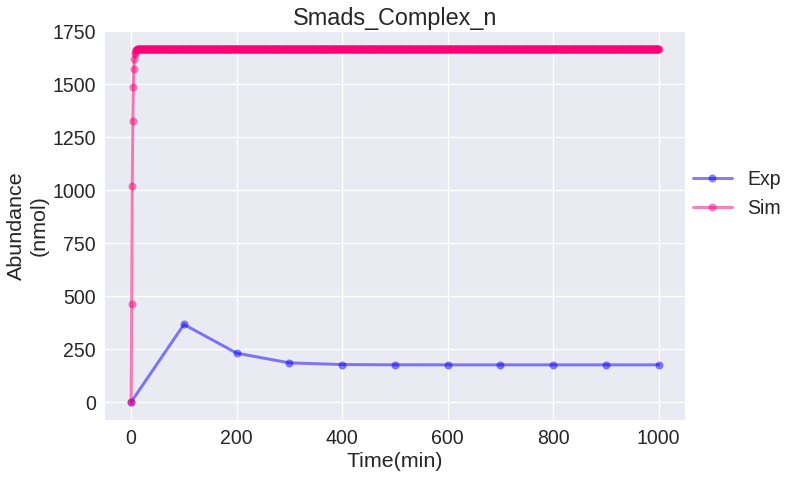

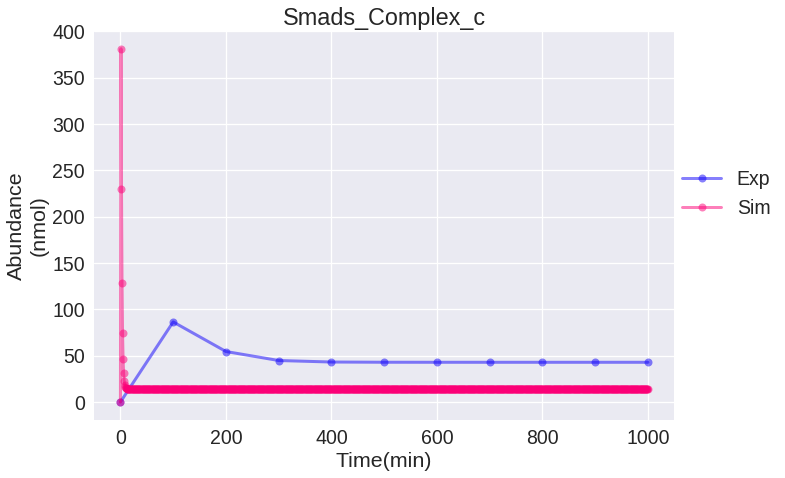

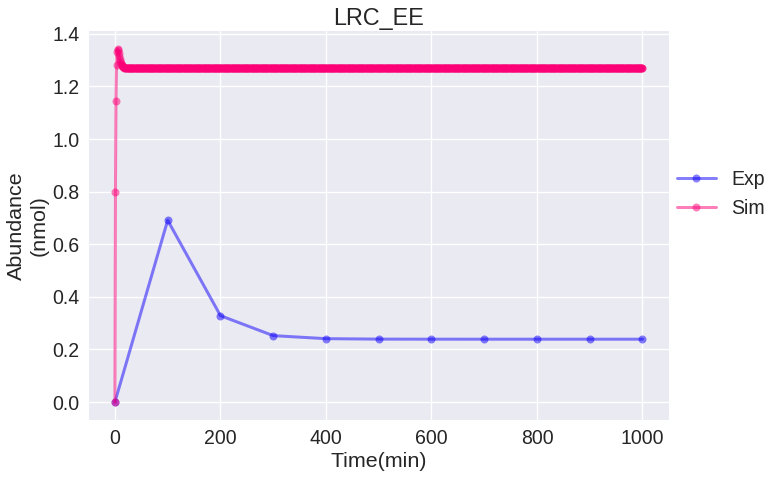

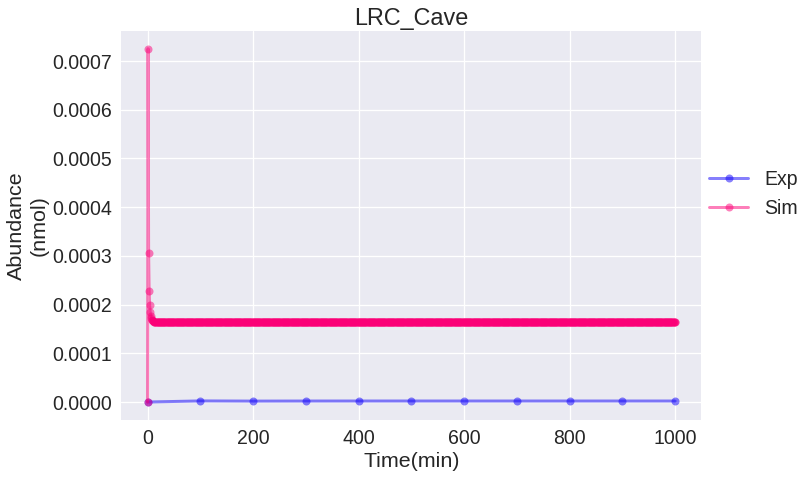

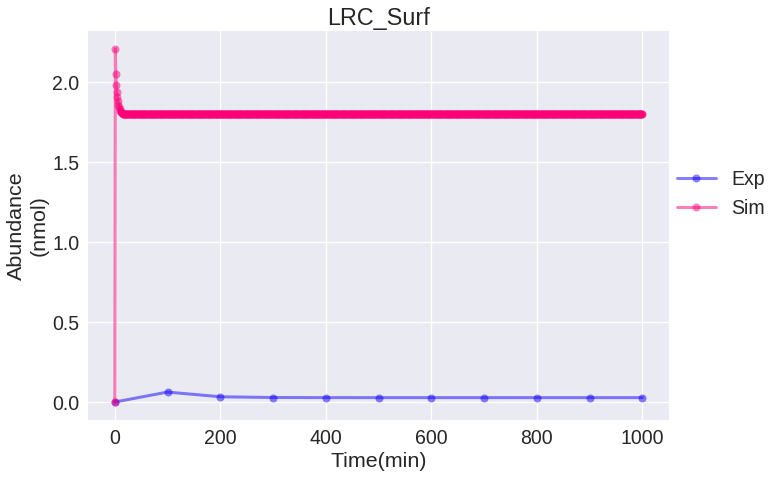

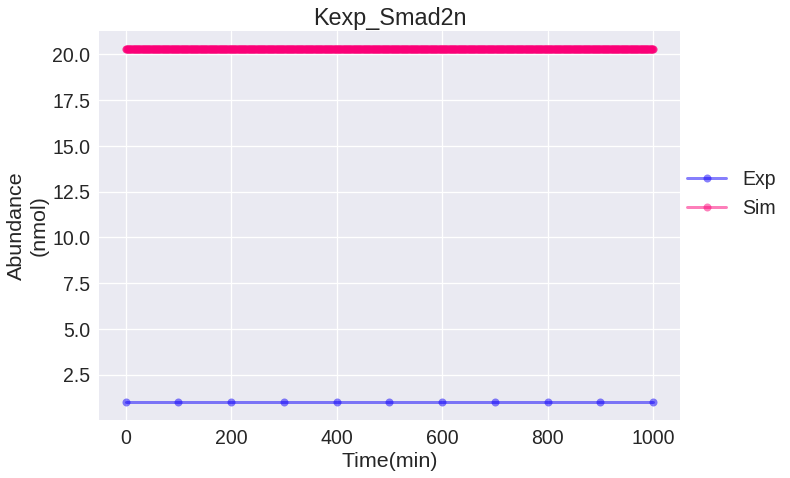

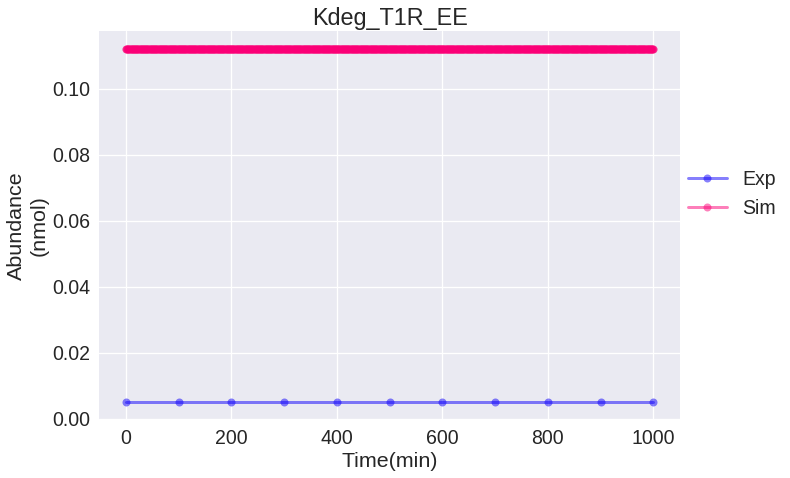

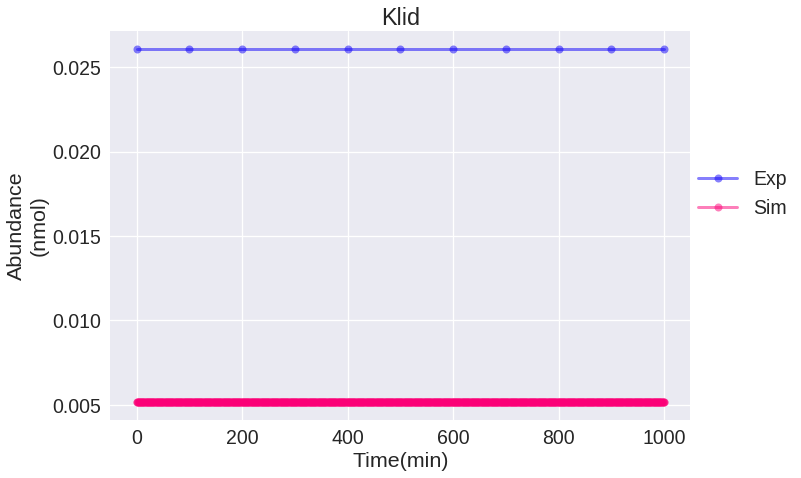

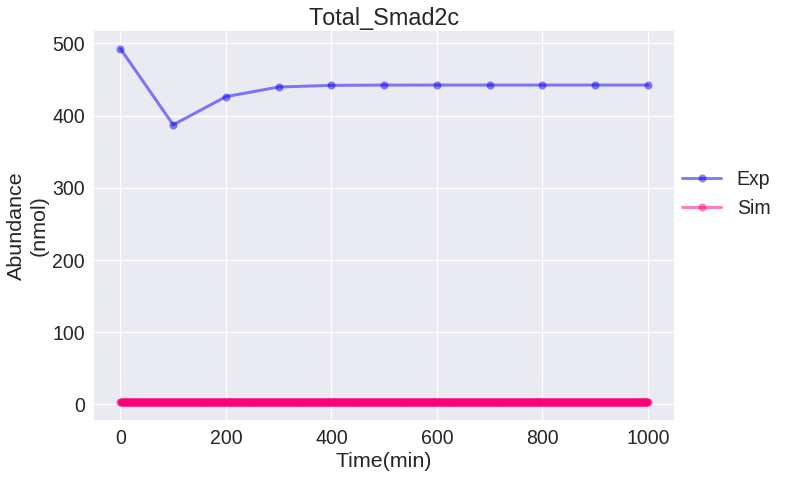

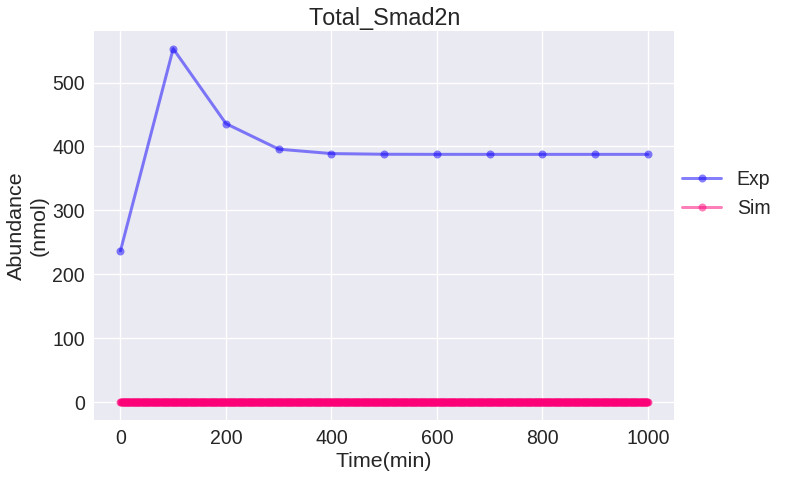

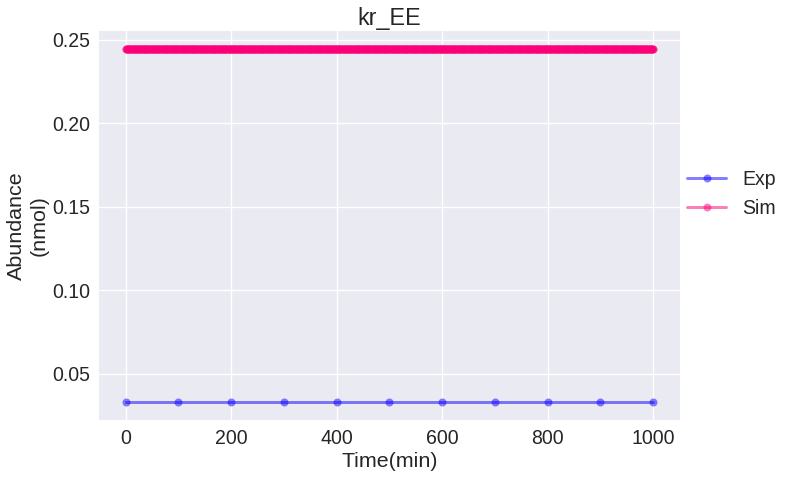

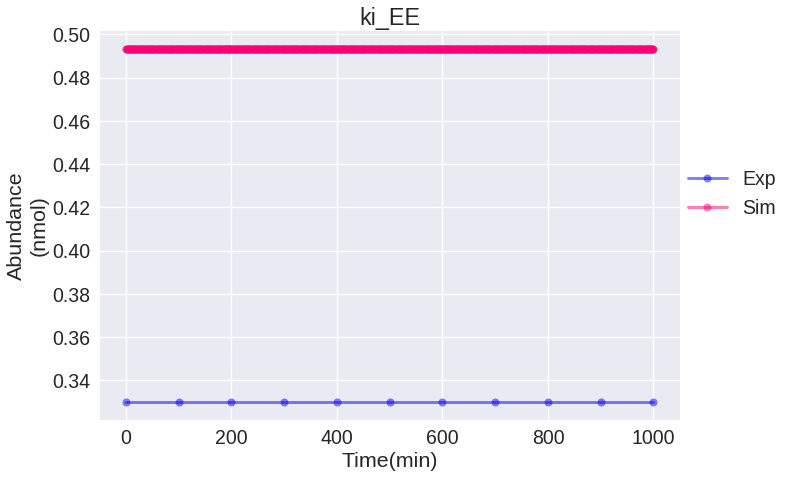

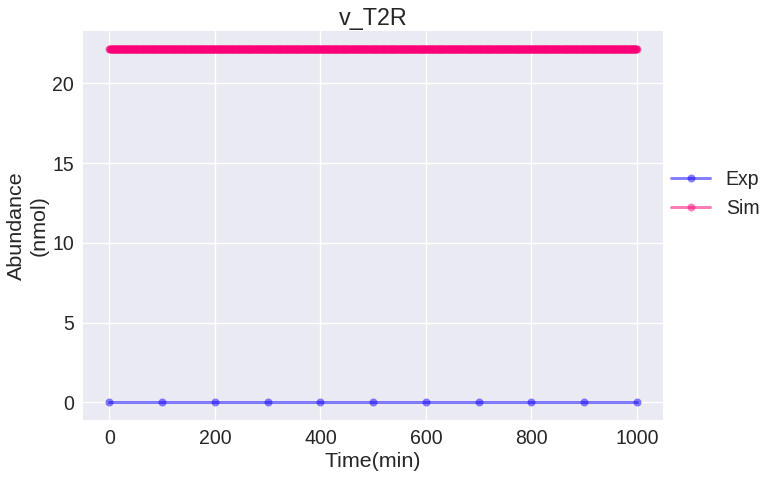

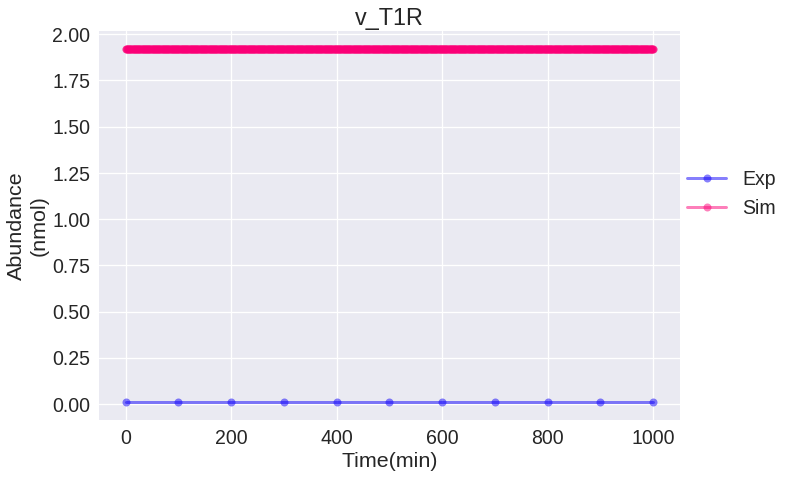

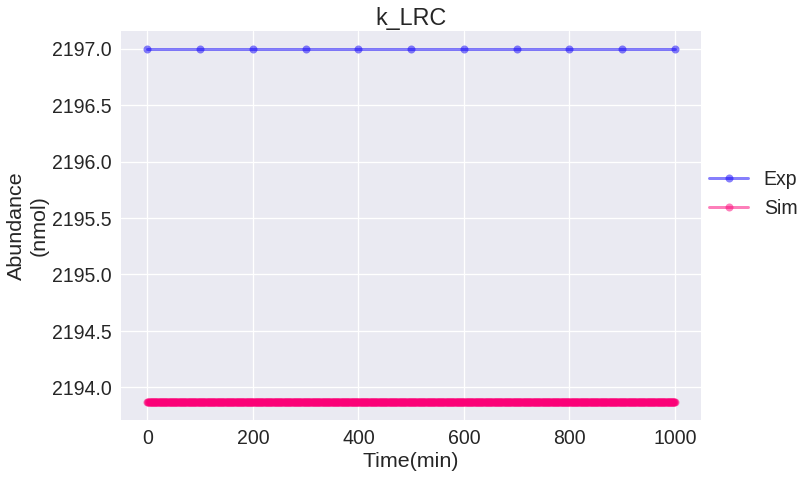

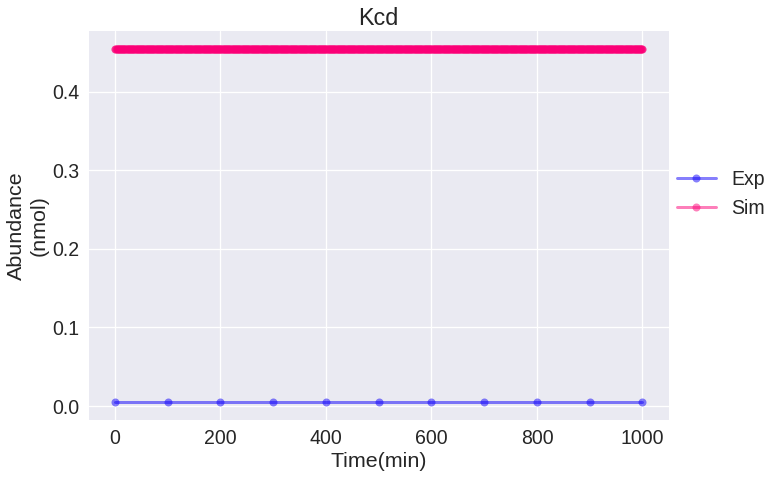

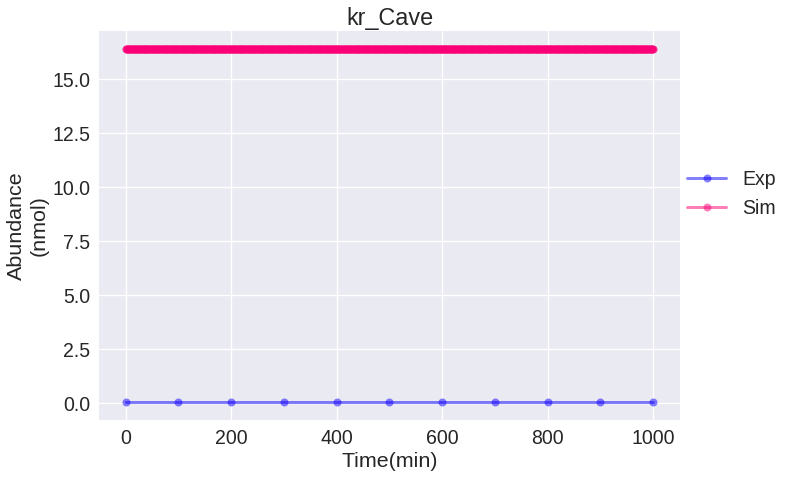

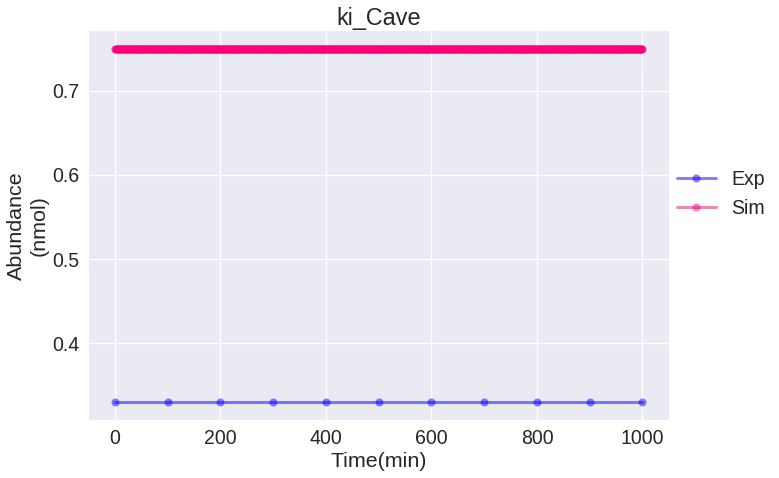

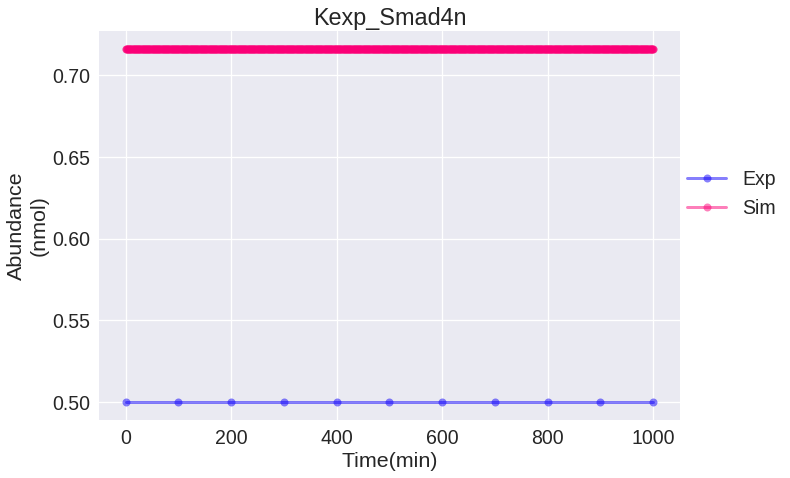

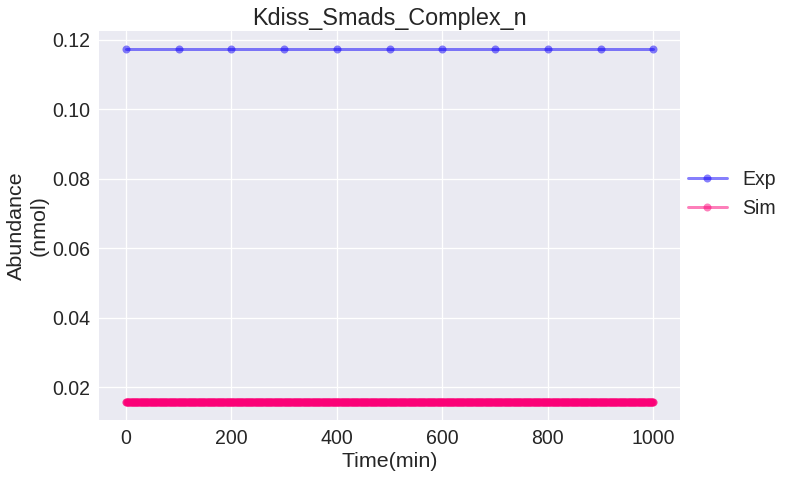

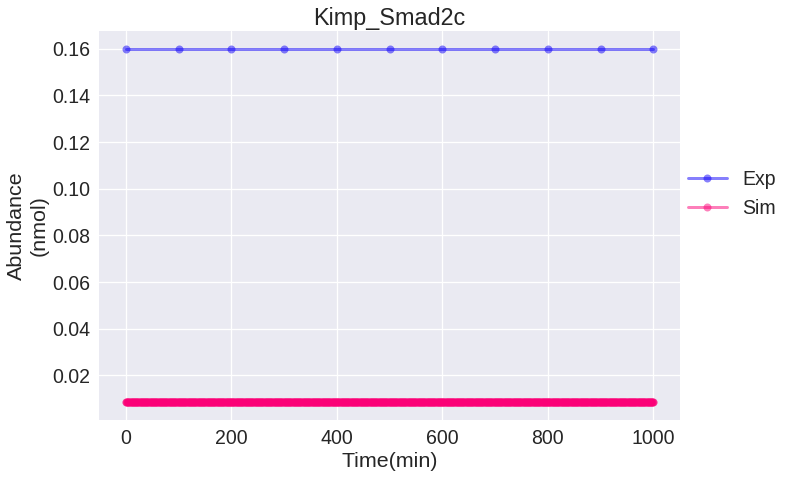

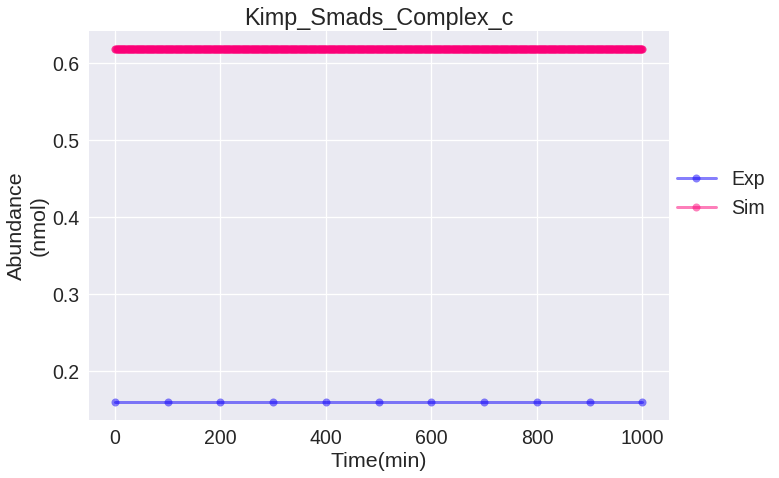

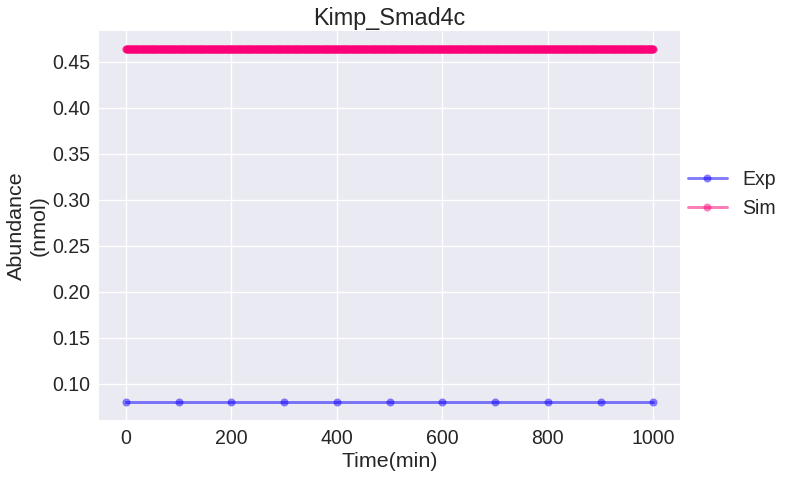

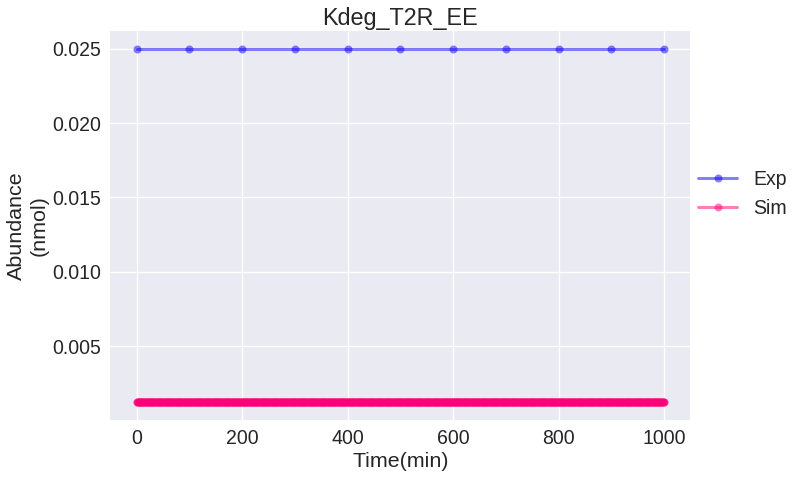

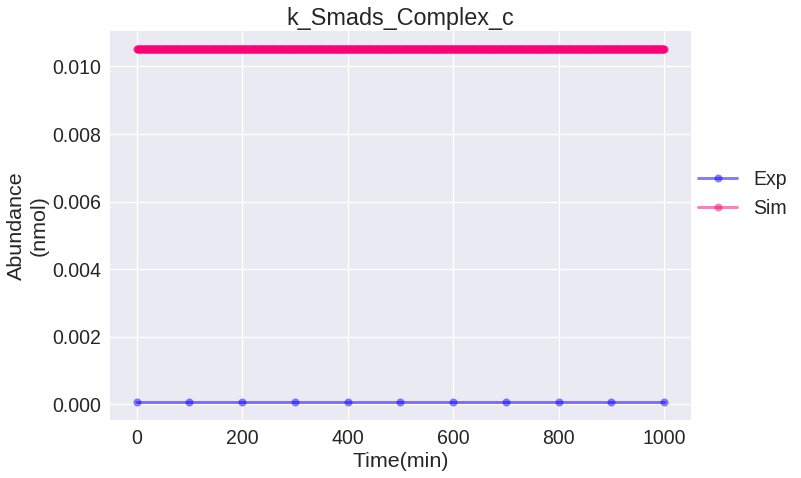

In [16]:
viz.PlotParameterEstimation(PE, savefig=True, results_directory='MyParameterEstimationResults')

### Select specific variables to plot

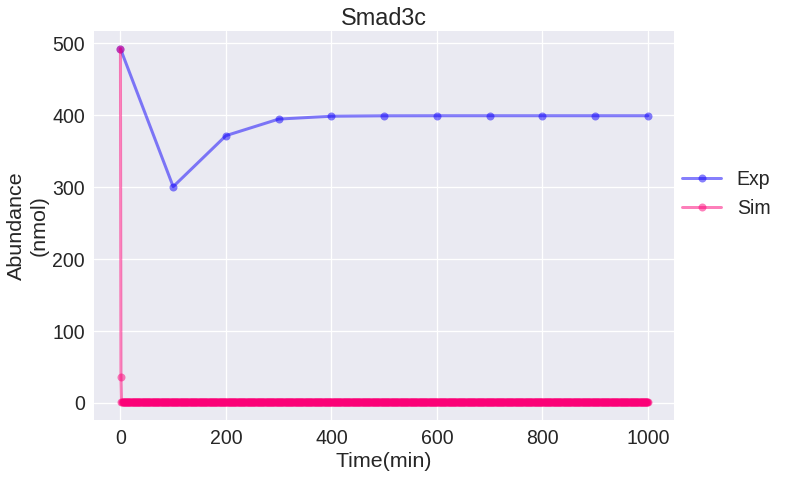

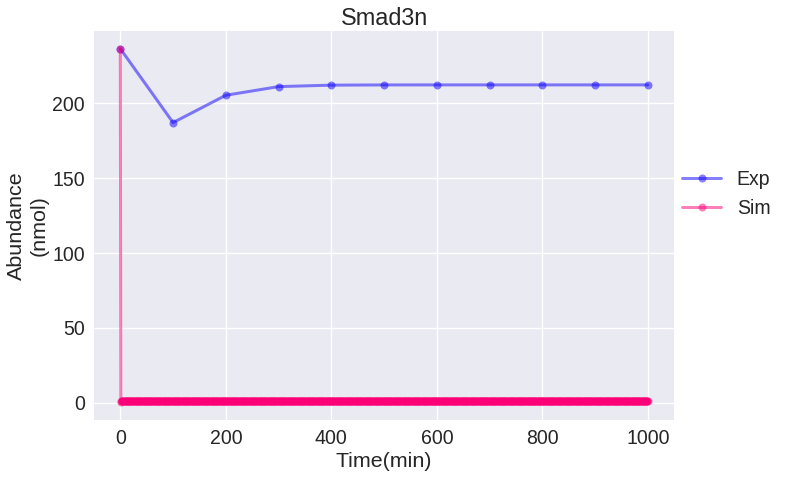

In [17]:
viz.PlotParameterEstimation(PE, y=['Smad3c', 'Smad3n'])

## Multiple Data Files
### Pre-requisites

#### Change a parameter value  
Pycotools can easily handle multiple data files by giving `ParameterEsimation` a list of data file paths. Lets simulate some more data.

Lets first change a model parameter so both sets of simulated data are not identical:

In [18]:
## set metabolite Smad3c concentration to 150 (original is 492.61)
zi.set('metabolite', 'Smad3c', 150, match_field='name', change_field='concentration')

## Uncomment to manually check the model to ensure Smad3c initial conc. is 150
#zi.open()

Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol)

#### Simulate second time course

In [19]:
report= 'parameter_estimation_synthetic_data2.txt'
TC=tasks.TimeCourse(zi,end=1000, intervals=10, step_size=100,
                    report_name=report, plot=True)
    

## Give fake data a meaningful name
zi_data_file2 = TC.report_name

#### Format the second synthetic time course data
Again, we can use the `misc.correct_copasi_timecourse_headers` function as a convenient way to properly formatting copasi time course data for parameter estimation. 

In [20]:
misc.correct_copasi_timecourse_headers(zi_data_file2)

Time   Smad4n    Smad4c      Smad3n     Smad3c  T2R_Surf        T1R_EE  \
0      0   551.72  1149.400  236.450000  150.00000     0.202  2.060000e+00   
1    100  1312.49   667.559    0.518038    0.39242   653.425  1.470950e-07   
2    200  1312.49   667.559    0.518038    0.39242  1240.060  1.865890e-08   
3    300  1312.49   667.559    0.518038    0.39242  1781.270  5.802130e-09   
4    400  1312.49   667.559    0.518038    0.39242  2280.580  2.588240e-09   
5    500  1312.49   667.559    0.518038    0.39242  2741.220  1.404590e-09   
6    600  1312.49   667.559    0.518038    0.39242  3166.200  8.622290e-10   
7    700  1312.49   667.559    0.518038    0.39242  3558.270  5.760180e-10   
8    800  1312.49   667.559    0.518038    0.39242  3919.990  4.092840e-10   
9    900  1312.49   667.559    0.518038    0.39242  4253.690  3.047790e-10   
10  1000  1312.49   667.559    0.518038    0.39242  4561.560  2.353340e-10   

        T1R_Cave      T1R_Surf    T2R_EE     ...       kr_Cave       Kcd  \
0   2.092000e+00  2.370000e-01     1.148     ...        16.415  0.454541   
1   4.451440e-09  9.727110e-08  1261.680     ...        16.415  0.454541   
2   5.914330e-10  1.293560e-08  2443.190     ...        16.415  0.454541   
3   1.866090e-10  4.082700e-09  3533.210     ...        16.415  0.454541   
4   8.384190e-11  1.834610e-09  4538.840     ...        16.415  0.454541   
5   4.569250e-11  9.999200e-10  5466.600     ...        16.415  0.454541   
6   2.812670e-11  6.155530e-10  6322.520     ...        16.415  0.454541   
7   1.882760e-11  4.120590e-10  7112.180     ...        16.415  0.454541   
8   1.339740e-11  2.932230e-10  7840.690     ...        16.415  0.454541   
9   9.988190e-12  2.186130e-10  8512.790     ...        16.415  0.454541   
10  7.719210e-12  1.689550e-10  9132.850     ...        16.415  0.454541   

    Kexp_Smad4n  k_Smads_Complex_c  Kimp_Smad2c  Kdiss_Smads_Complex_n  \
0      0.716188           0.010521     0.008633               0.015741   
1      0.716188           0.010521     0.008633               0.015741   
2      0.716188           0.010521     0.008633               0.015741   
3      0.716188           0.010521     0.008633               0.015741   
4      0.716188           0.010521     0.008633               0.015741   
5      0.716188           0.010521     0.008633               0.015741   
6      0.716188           0.010521     0.008633               0.015741   
7      0.716188           0.010521     0.008633               0.015741   
8      0.716188           0.010521     0.008633               0.015741   
9      0.716188           0.010521     0.008633               0.015741   
10     0.716188           0.010521     0.008633               0.015741   

    Kimp_Smad4c  Kimp_Smads_Complex_c   ki_Cave  Kdeg_T2R_EE  
0      0.464117               0.61899  0.749857     0.001224  
1      0.464117               0.61899  0.749857     0.001224  
2      0.464117               0.61899  0.749857     0.001224  
3      0.464117               0.61899  0.749857     0.001224  
4      0.464117               0.61899  0.749857     0.001224  
5      0.464117               0.61899  0.749857     0.001224  
6      0.464117               0.61899  0.749857     0.001224  
7      0.464117               0.61899  0.749857     0.001224  
8      0.464117               0.61899  0.749857     0.001224  
9      0.464117               0.61899  0.749857     0.001224  
10     0.464117               0.61899  0.749857     0.001224  

[11 rows x 37 columns]

#### Add independent variable
We are now setting up a parameter estimation where the Smad3c metabolite contains two separate initial conditions. These are handled by Copasi using independent variables ([see docs](http://copasi.org/Support/User_Manual/Tasks/Parameter_Estimation/)). 

In [21]:
def add_independent_variable(data_file, indep_var, value):
    """
    
    :param data_file: str. Path to pre-formatted time course data
    :param indep_var: str. Variable to add independent var for
    :param value: (int, float). Amount to set as independent
    :return: pandas.DataFrame. With independent variable as new column
    """
    ## read the data file into pandas
    df = pandas.read_csv(data_file, sep='\t', index_col=0)
    
    ## validate user input
    if indep_var not in list(df.columns):
        raise Exception
        
    ## ensure we don't add a indep_var twice
    if indep_var+'_indep' in list(df.columns):
        return df
    
    ## add independent variable column
    ## Append '_indep' to variable name to tell pycotools that its independent
    df[indep_var+'_indep'] = value
    
#     ## remove original data file
#     if os.path.isfile(data_file):
#         os.remove(data_file)
    
    
    ## write data file with indep value 
#     df.to_csv(data_file[:-4]+'_2.txt', sep='\t', index=True)
    df.to_csv(data_file, sep='\t', index=True)
    return df

## add independent variable to first set of synthetic data
add_independent_variable(zi_data_file, 'Smad3c', 492.61)

## add independent variable to first set of synthetic data
add_independent_variable(zi_data_file2, 'Smad3c', 150)

Smad4n    Smad4c      Smad3n     Smad3c  T2R_Surf        T1R_EE  \
Time                                                                     
0      551.72  1149.400  236.450000  150.00000     0.202  2.060000e+00   
100   1312.49   667.559    0.518038    0.39242   653.425  1.470950e-07   
200   1312.49   667.559    0.518038    0.39242  1240.060  1.865890e-08   
300   1312.49   667.559    0.518038    0.39242  1781.270  5.802130e-09   
400   1312.49   667.559    0.518038    0.39242  2280.580  2.588240e-09   
500   1312.49   667.559    0.518038    0.39242  2741.220  1.404590e-09   
600   1312.49   667.559    0.518038    0.39242  3166.200  8.622290e-10   
700   1312.49   667.559    0.518038    0.39242  3558.270  5.760180e-10   
800   1312.49   667.559    0.518038    0.39242  3919.990  4.092840e-10   
900   1312.49   667.559    0.518038    0.39242  4253.690  3.047790e-10   
1000  1312.49   667.559    0.518038    0.39242  4561.560  2.353340e-10   

          T1R_Cave      T1R_Surf    T2R_EE  T2R_Cave      ...            Kcd  \
Time                                                      ...                  
0     2.092000e+00  2.370000e-01     1.148    1.7780      ...       0.454541   
100   4.451440e-09  9.727110e-08  1261.680   29.8322      ...       0.454541   
200   5.914330e-10  1.293560e-08  2443.190   56.6317      ...       0.454541   
300   1.866090e-10  4.082700e-09  3533.210   81.3561      ...       0.454541   
400   8.384190e-11  1.834610e-09  4538.840  104.1660      ...       0.454541   
500   4.569250e-11  9.999200e-10  5466.600  125.2100      ...       0.454541   
600   2.812670e-11  6.155530e-10  6322.520  144.6240      ...       0.454541   
700   1.882760e-11  4.120590e-10  7112.180  162.5360      ...       0.454541   
800   1.339740e-11  2.932230e-10  7840.690  179.0600      ...       0.454541   
900   9.988190e-12  2.186130e-10  8512.790  194.3050      ...       0.454541   
1000  7.719210e-12  1.689550e-10  9132.850  208.3690      ...       0.454541   

      Kexp_Smad4n  k_Smads_Complex_c  Kimp_Smad2c  Kdiss_Smads_Complex_n  \
Time                                                                       
0        0.716188           0.010521     0.008633               0.015741   
100      0.716188           0.010521     0.008633               0.015741   
200      0.716188           0.010521     0.008633               0.015741   
300      0.716188           0.010521     0.008633               0.015741   
400      0.716188           0.010521     0.008633               0.015741   
500      0.716188           0.010521     0.008633               0.015741   
600      0.716188           0.010521     0.008633               0.015741   
700      0.716188           0.010521     0.008633               0.015741   
800      0.716188           0.010521     0.008633               0.015741   
900      0.716188           0.010521     0.008633               0.015741   
1000     0.716188           0.010521     0.008633               0.015741   

      Kimp_Smad4c  Kimp_Smads_Complex_c   ki_Cave  Kdeg_T2R_EE  Smad3c_indep  
Time                                                                          
0        0.464117               0.61899  0.749857     0.001224           150  
100      0.464117               0.61899  0.749857     0.001224           150  
200      0.464117               0.61899  0.749857     0.001224           150  
300      0.464117               0.61899  0.749857     0.001224           150  
400      0.464117               0.61899  0.749857     0.001224           150  
500      0.464117               0.61899  0.749857     0.001224           150  
600      0.464117               0.61899  0.749857     0.001224           150  
700      0.464117               0.61899  0.749857     0.001224           150  
800      0.464117               0.61899  0.749857     0.001224           150  
900      0.464117               0.61899  0.749857     0.001224           150  
1000     0.464117               0.61899  0.749857     0.001224    

### Setup parameter estimation with two data files
Pycotools can handle an arbitrary number of parameter estimation files at a time by passing a list of properly configured COPASI data files rather than a single string. 

Here we setup a parameter estimation to estimate all global variables using the two data files which were simulated from the model but with different starting values of Smad3c

In [22]:
config_file2 = os.path.join(os.path.dirname(zi_path), 'zi_config_file2.xlsx')
PE=tasks.ParameterEstimation(
    zi,[zi_data_file, zi_data_file2], method='genetic_algorithm',
    population_size=5, number_of_generations=20,
    metabolites=[], local_parameters=[], lower_bound=0.1, 
    upper_bound=100, config_filename=config_file2)
PE.write_config_file()
PE.setup()

Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol)

### Run parameter estimation with two data files

In [23]:
PE.run()

## Visualization 
The same arguments apply as when plotting parameter estimation from a single data file

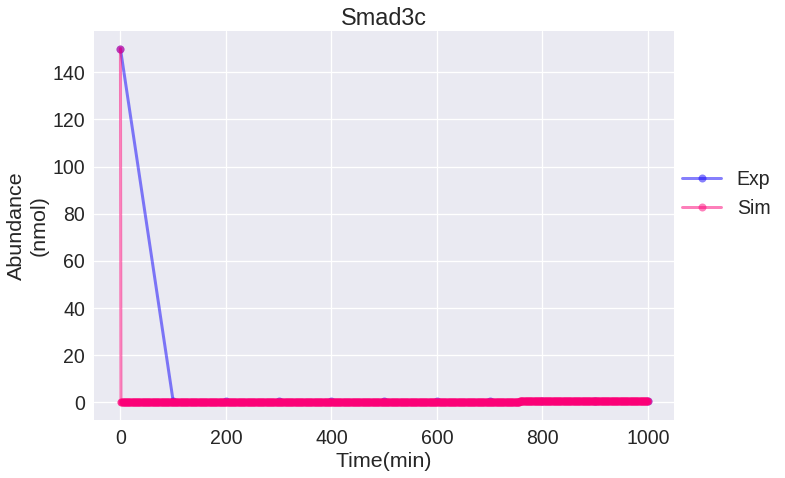

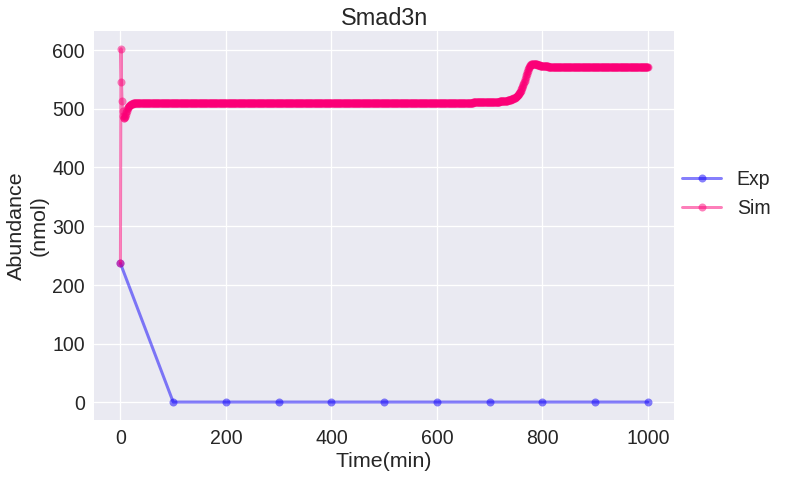

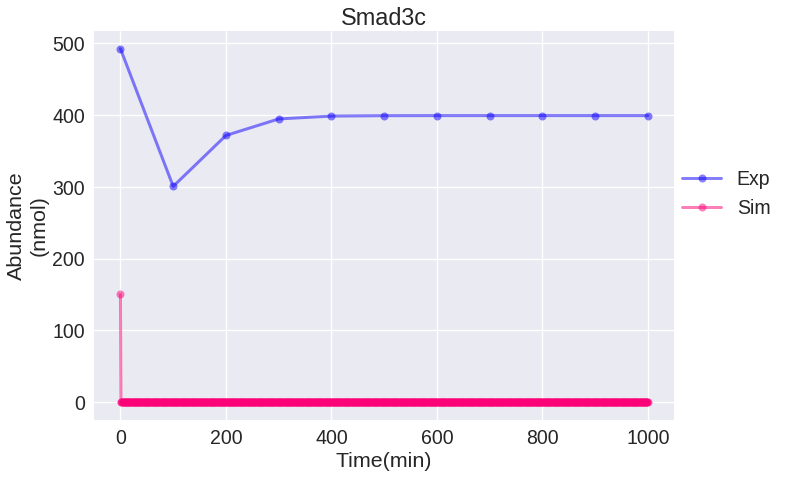

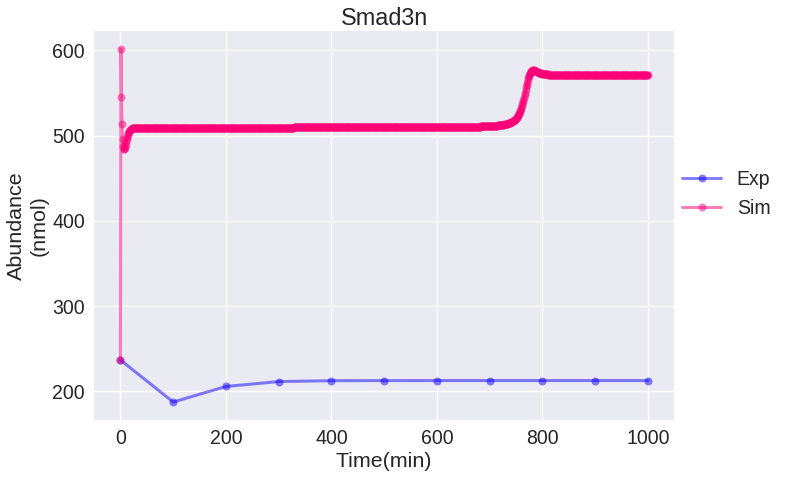

In [24]:
viz.PlotParameterEstimation(PE, y=['Smad3c', 'Smad3n'])

## Steady State data
By default, all data files are timecourse. To specify timecourse data we need to add a few more arguments to the ParameterEstimation instantiation - namely the experiment type argument. 

#### Create fake steady state data

In [27]:
steady_state_data_file = os.path.join(os.path.dirname(zi_path), 'steady_state_data')
df = pandas.DataFrame([400], columns=['Smad3c'])
df.to_csv(steady_state_data_file, index=False)

### Setup parameter estimation with steady state

In [28]:
config_file = os.path.join(os.path.dirname(zi_path), 'Zi2002PEConfig3.csv')
PE = tasks.ParameterEstimation(
    zi, [zi_data_file, steady_state_data_file],
    experiment_type=['timecourse', 'steadystate'],
    weight_method=['mean_squared', 'mean_squared'],
    method='genetic_algorithm', population_size=15,
    number_of_generations=10, metabolites=[], local_parameters=[],
    lower_bound = 0.001, upper_bound = 3000, config_filename = config_file
)
PE.write_config_file()
PE.setup()

Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol)

Running and visualization are now the same aas described previously. 